In [75]:
%install_ext https://raw.githubusercontent.com/szeitlin/watermark/master/watermark.py

Installed watermark.py. To use it, type:
  %load_ext watermark


In [76]:
%load_ext watermark

In [18]:
import pandas
from pandas.stats.api import ols
from dateutil.parser import parse
import pytz

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

%matplotlib inline

In [81]:
#%watermark -a "Samantha Zeitlin" -d -u -p python,ipython,pandas,seaborn,sklearn,pytz,matplotlib

In [19]:
font = {'family': 'arial',
        'weight': 'regular',
        'size' : 30}
matplotlib.rc('font', **font)

In [91]:
df = pandas.read_csv("2014_ts.csv",index_col=0, nrows=2000) #just use a subset of the data for testing 

In [92]:
df['parsed']=[parse(x) for x in df['posTime']]
df['zoned'] = [x.astimezone(pytz.timezone('US/Pacific')) for x in df['parsed']]
df.head()

posTime      Lat      Long                    altTime  \
0  2014-10-16 07:48:11-07:00  37.3943 -122.0769  2014-10-16 07:48:11-07:00   
1  2014-10-16 07:48:12-07:00  37.3943 -122.0771  2014-10-16 07:48:12-07:00   
2  2014-10-16 07:48:17-07:00  37.3944 -122.0774  2014-10-16 07:48:17-07:00   
3  2014-10-16 07:48:26-07:00  37.3947 -122.0781  2014-10-16 07:48:26-07:00   
4  2014-10-16 07:48:29-07:00  37.3948 -122.0782  2014-10-16 07:48:29-07:00   

   Altitude  DistanceMeters  weekday                     parsed  \
0   19.3638       4780.8071        3  2014-10-16 07:48:11-07:00   
1   19.3638       4791.6362        3  2014-10-16 07:48:12-07:00   
2   19.8444       4826.5288        3  2014-10-16 07:48:17-07:00   
3   19.8444       4895.5474        3  2014-10-16 07:48:26-07:00   
4   19.8444       4916.4795        3  2014-10-16 07:48:29-07:00   

                       zoned  
0  2014-10-16 07:48:11-07:00  
1  2014-10-16 07:48:12-07:00  
2  2014-10-16 07:48:17-07:00  
3  2014-10-16 07:48:26-07:00  
4  2014-10-16 07:48:29-07:00

In [93]:
df = df.sort_index(by='zoned').reset_index()

In [94]:
df['date']=[x.date() for x in df['zoned']]
df.head()

index                    posTime      Lat      Long  \
0   1454  2014-06-24 18:27:16-07:00  37.7577 -122.3923   
1   1477  2014-06-24 18:27:16-07:00  37.7577 -122.3923   
2   1455  2014-06-24 18:27:17-07:00  37.7577 -122.3922   
3   1478  2014-06-24 18:27:17-07:00  37.7577 -122.3922   
4   1456  2014-06-24 18:27:18-07:00  37.7577 -122.3921   

                     altTime  Altitude  DistanceMeters  weekday  \
0  2014-06-24 18:27:16-07:00   12.6344      14080.3379        1   
1  2014-06-24 18:27:16-07:00   12.6344      14080.3379        1   
2  2014-06-24 18:27:17-07:00   12.6344      14086.3379        1   
3  2014-06-24 18:27:17-07:00   12.6344      14086.3379        1   
4  2014-06-24 18:27:18-07:00   12.6344      14092.4209        1   

                      parsed                      zoned        date  
0  2014-06-24 18:27:16-07:00  2014-06-24 18:27:16-07:00  2014-06-24  
1  2014-06-24 18:27:16-07:00  2014-06-24 18:27:16-07:00  2014-06-24  
2  2014-06-24 18:27:17-07:00  2014-06-24 18:27:17-07:00  2014-06-24  
3  2014-06-24 18:27:17-07:00  2014-06-24 18:27:17-07:00  2014-06-24  
4  2014-06-24 18:27:18-07:00  2014-06-24 18:27:18-07:00  2014-06-24

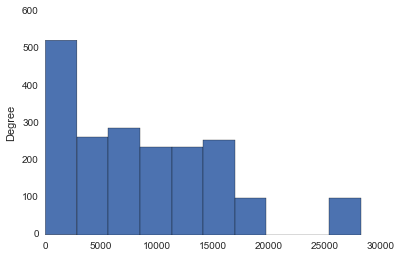

In [95]:
df['DistanceMeters'].plot(kind='hist')

In [96]:
df.shape

(2000, 11)

In [97]:
df['date'].value_counts()

2014-10-16    490
2014-10-08    480
2014-10-21    406
2014-10-17    166
2014-07-21    126
2014-07-07     84
2014-10-20     78
2014-10-07     68
2014-07-08     56
2014-06-24     46
dtype: int64

In [98]:
#for row in df, while date.next == date.previous, append to list
#otherwise, stop and create new list 

def split_alts_by_date(df, datecolname):
    """ Create lists of altitudes from points visited on the same day (dates will be the same, times will vary).
    
    Note: assumes the df is sorted, with index reset, such that index follows the right order for sequential date values.
    
    sorted df (dataframe), datecolname (str) -> generator of lists of altitudes in meters
    
    """
    alt_list = []
    
    temp_date = df[datecolname][0].date()
    for item in df.index.values:  
        if df[datecolname][item].date() == temp_date:
            alt_list.append((df['DistanceMeters'][item], df['Altitude'][item]))
        
        else:
            temp_date = df[datecolname][item].date()
            yield alt_list
            print len(alt_list)
            alt_list = []

In [103]:
def check_for_non_sequential_distances(alt_list):
    """
    See if this is simpler than the fancy linear fit filter idea. 
    Just check whether distance goes down instead of up, and if it goes down, don't copy it to the new list
    
    :param alt_list: list of tuples with (Distance, Altitude)
    :return filtered: shorter list of tuples
    
    """
    
    while alt_list:
        try:
            filtered = []
            original = next(alt_list)
            compare = original[0]
            
            for x,y in original:
                if x <= compare[0]: 
                    continue 
                elif x >compare[0]:
                    filtered.append((x,y))
                    compare = (x,y)

            yield filtered
            print len(filtered)
        except StopIteration:
            break 

In [104]:
alt_list = split_alts_by_date(df,'zoned')
filtered = check_for_non_sequential_distances(alt_list)
next(filtered)

[(14086.3379, 12.634399999999999),
 (14092.420899999999, 12.634399999999999),
 (14100.367200000001, 12.634399999999999),
 (14150.738300000001, 11.6732),
 (14165.6055, 11.6732),
 (14170.7246, 11.6732),
 (14178.497100000001, 11.6732),
 (14186.7402, 11.6732),
 (14229.3711, 13.1151),
 (14289.545899999999, 13.595800000000001),
 (14342.559600000001, 12.1538),
 (14396.333000000001, 13.1151),
 (14456.6777, 13.595800000000001),
 (14507.1924, 14.0764),
 (14566.834999999999, 13.595800000000001),
 (14628.790000000001, 13.1151),
 (14693.7441, 13.595800000000001),
 (14746.9629, 12.634399999999999),
 (14781.543, 11.192500000000001),
 (14846.4463, 12.1538),
 (14873.999, 10.7118),
 (14883.742200000001, 8.7891999999999992)]

In [33]:
def collapse_to_unique_points(alt_list):
    """ Remove adjacent duplicates. 

    :param alt_list: list of tuples
    :return: points: shorter list of tuples
    """
    points = []
    print len(alt_list)
    for item in alt_list:
        if len(points)==0 or item != points[-1]:  #compare to element most recently appended to points
            points.append(item)
    print len(points)
    return points

In [34]:
def plot_maker():
    """
    Helper function to set up a new plot with the formatting I want. 
    
    :param dist_df: dataframe with distance and altitude columns
    :return: a plot 
    
    """
    dist_df = df_maker(df, 'zoned')
    
    while dist_df:
        try:
            plot_frame = next(dist_df)
            fig= plt.figure(figsize=(8,4),dpi=250)
            ax = fig.add_subplot(111)
            ax.plot(plot_frame['distance'],plot_frame['altitude'])
            ax.set_ylabel('Altitude(meters)', fontsize=20)
            ax.set_xlabel('Distance(meters)', fontsize=20)
            plt.xticks(fontsize=15)
            plt.yticks(fontsize=15)
        except StopIteration:
            break 

In [76]:
def df_maker(df, datecolname):
    """
    Generator to yield individual data frames from each alt_list. 
    """
    alt_list = split_alts_by_date(df, 'zoned')
    filtered = check_for_non_sequential_distances(alt_list)
    
    while filtered:
        try:
            points = next(filtered)
            dist_df = pandas.DataFrame(points, columns=['distance','altitude'])
            print dist_df.count()
            yield dist_df
            
        except StopIteration:
            break
    

In [81]:
dist_df = df_maker(df, 'zoned')
plot_frame = next(dist_df)
next(dist_df)

(21.472300000000001, 53.009799999999998)
distance    26
altitude    26
dtype: int64
26
distance    27
altitude    27
dtype: int64


distance  altitude
0    21.4723   53.0098
1    27.8743   53.0098
2    93.1674   53.0098
3   114.1827   52.0486
4   130.7530   53.4905
5   135.8203   53.0098
6   182.1245   53.0098
7   226.9922   52.5292
8   268.5215   52.0486
9   334.3421   53.0098
10  375.1497   52.0486
11  417.3502   52.0486
12  463.1673   52.5292
13  519.3424   52.5292
14  576.1154   52.0486
15  633.5293   51.0872
16  700.6275   50.1260
17  759.3484   50.1260
18  809.2172   50.6066
19  872.0473   51.0872
20  886.1664   51.0872
21  904.2343   50.1260
22  917.2053   51.0872
23  936.8862   50.1260
24  954.8820   50.1260
25  961.2960   49.6453
26  961.2960   49.6453

(21.472300000000001, 53.009799999999998)
distance    26
altitude    26
dtype: int64
26
distance    27
altitude    27
dtype: int64
27
distance    28
altitude    28
dtype: int64
28
distance    29
altitude    29
dtype: int64
29
distance    30
altitude    30
dtype: int64
30
distance    31
altitude    31
dtype: int64
31
distance    32
altitude    32
dtype: int64
32
distance    33
altitude    33
dtype: int64
33
distance    34
altitude    34
dtype: int64
34
distance    35
altitude    35
dtype: int64
35
distance    36
altitude    36
dtype: int64
36
distance    37
altitude    37
dtype: int64
37
distance    38
altitude    38
dtype: int64
38
distance    39
altitude    39
dtype: int64
39
distance    40
altitude    40
dtype: int64
40
distance    41
altitude    41
dtype: int64
41
distance    42
altitude    42
dtype: int64
42
distance    43
altitude    43
dtype: int64
43
distance    44
altitude    44
dtype: int64
44
distance    45
altitude    45
dtype: int64
45
distance    46
altitude    46
dtype: in

KeyboardInterrupt: 

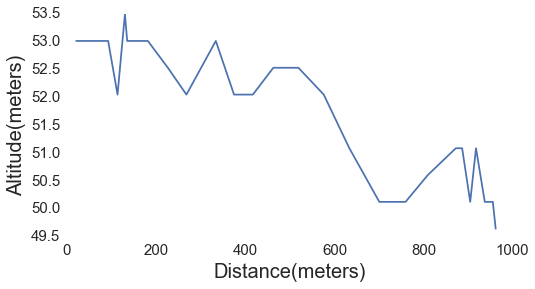

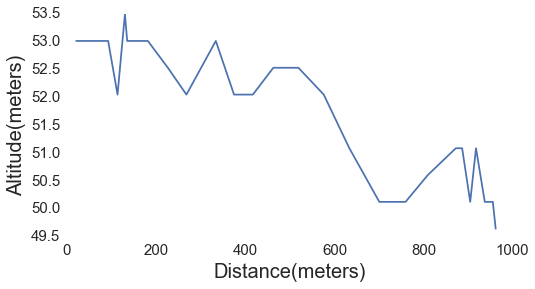

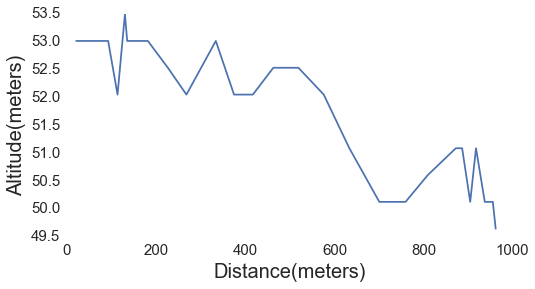

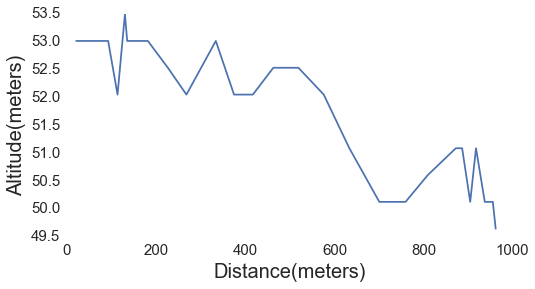

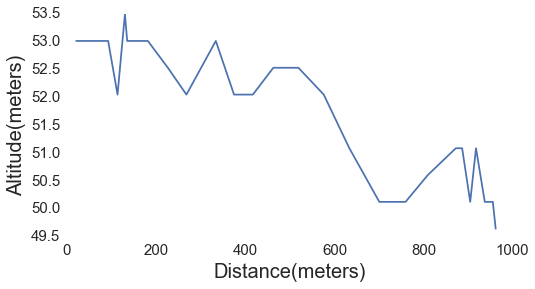

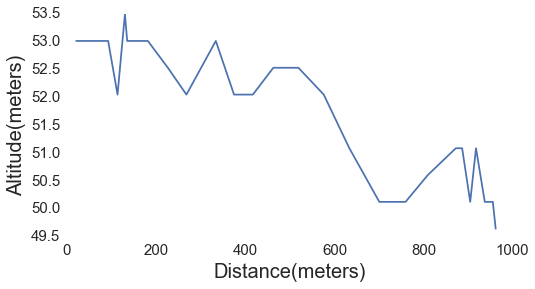

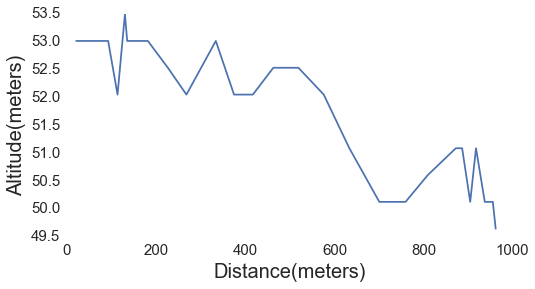

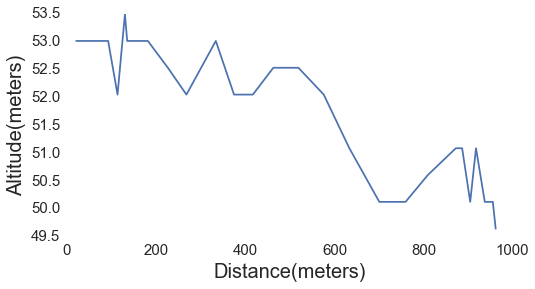

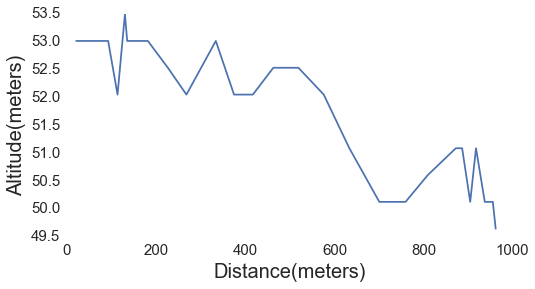

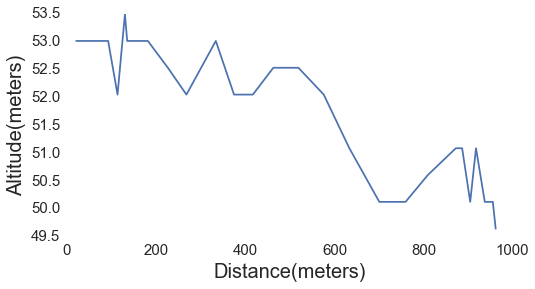

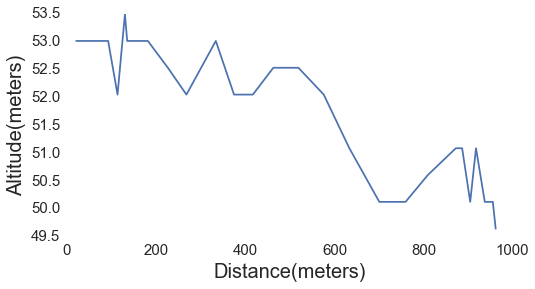

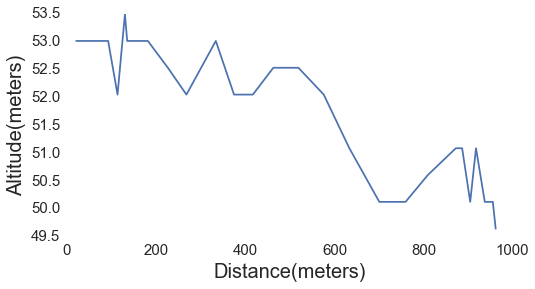

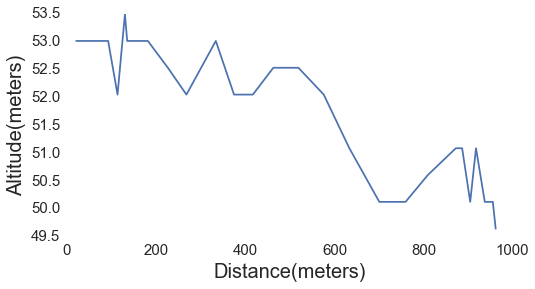

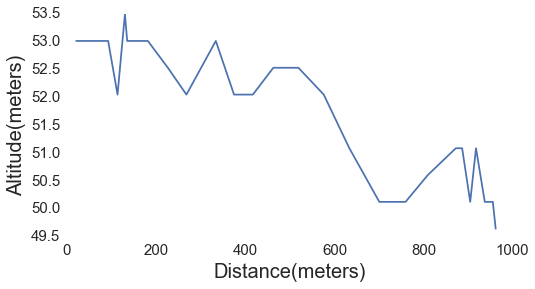

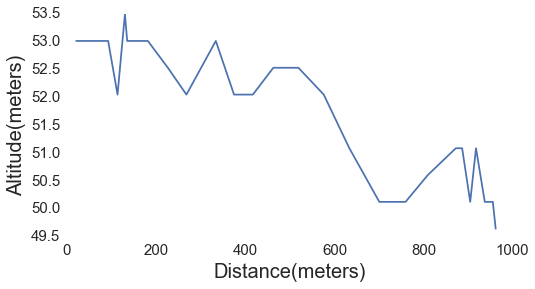

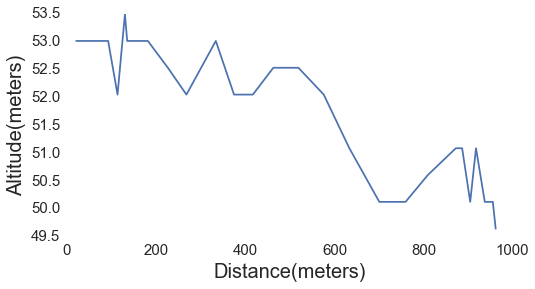

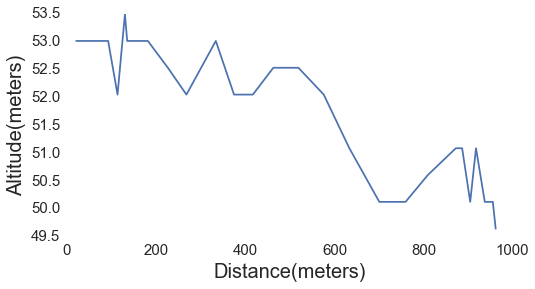

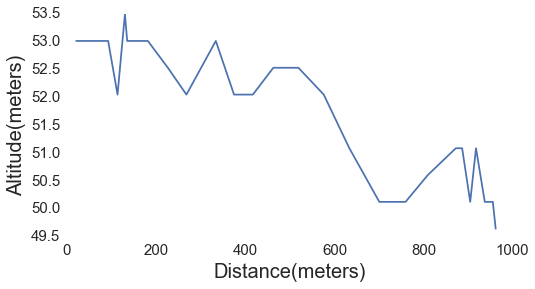

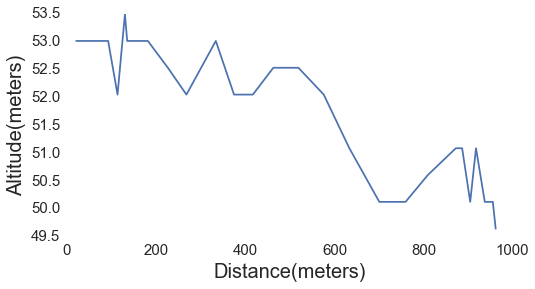

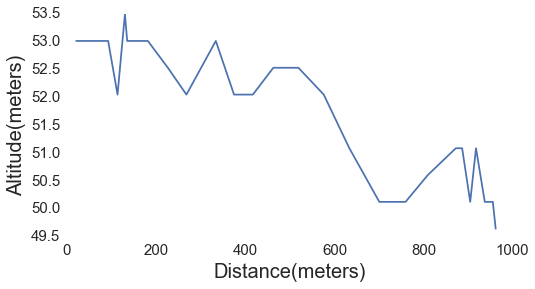

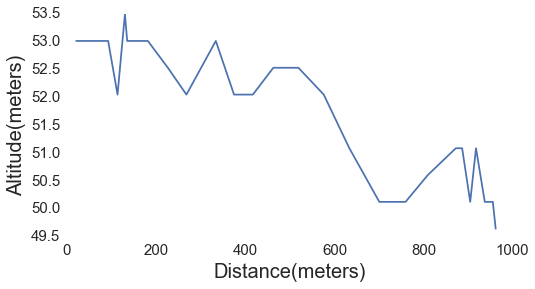

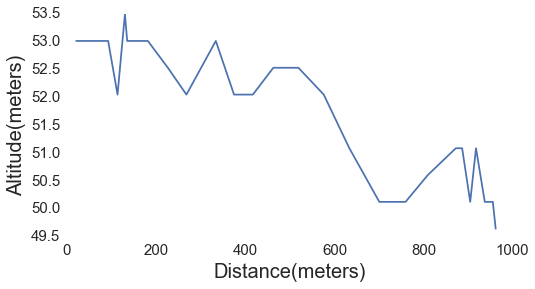

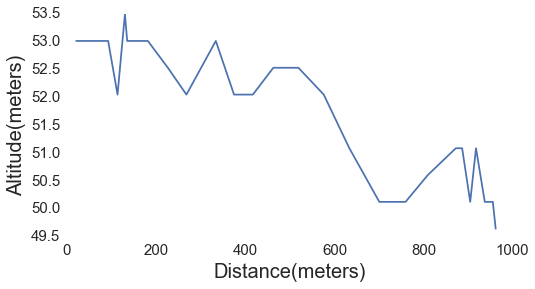

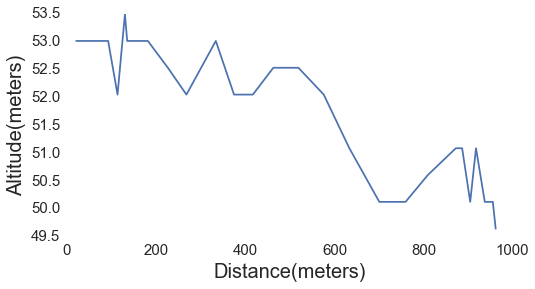

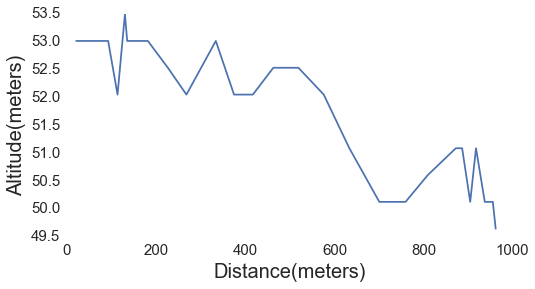

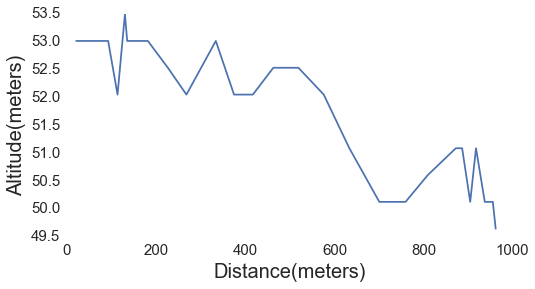

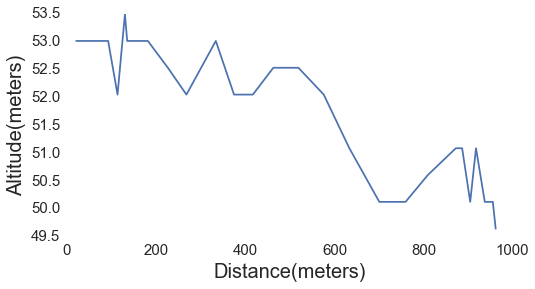

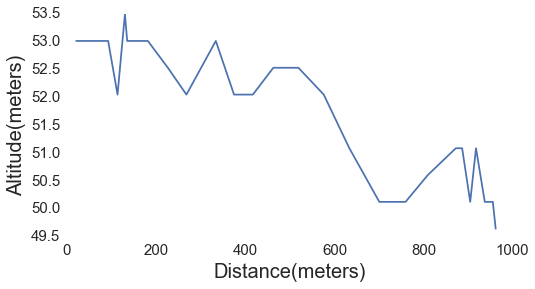

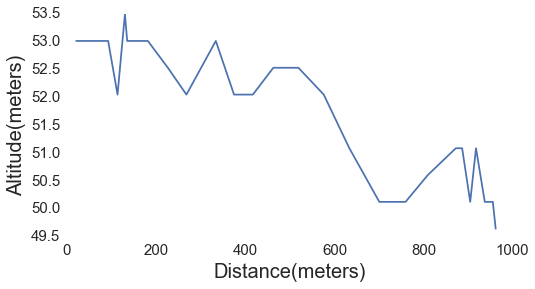

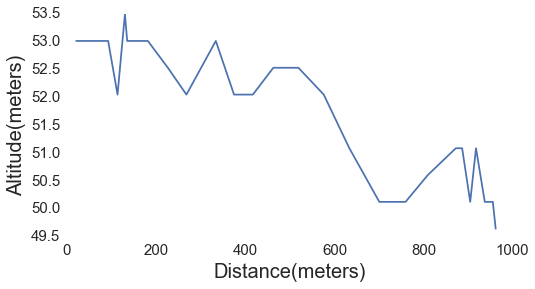

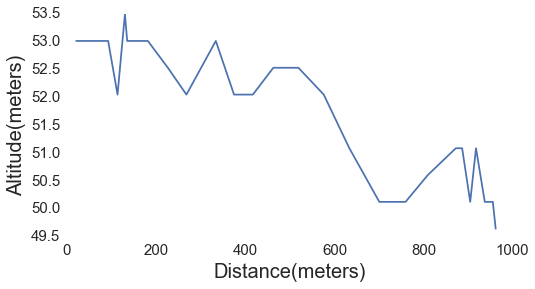

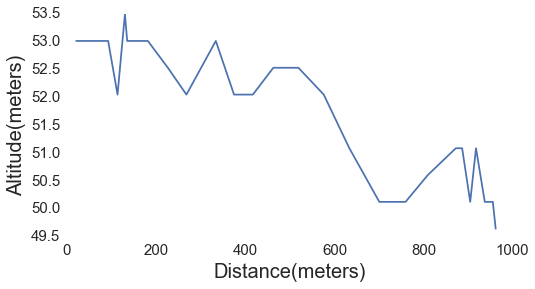

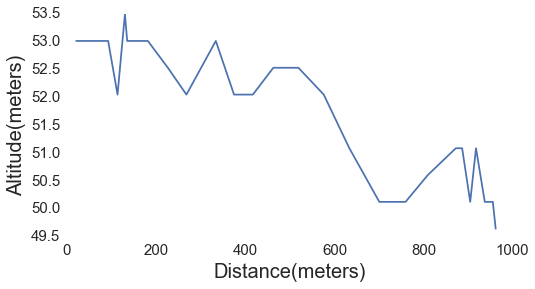

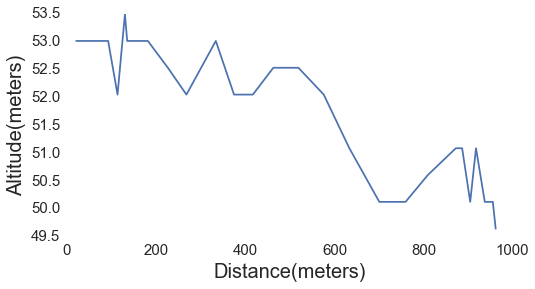

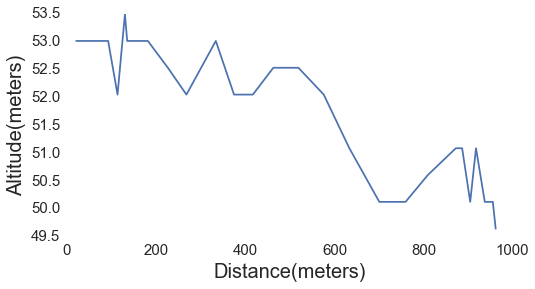

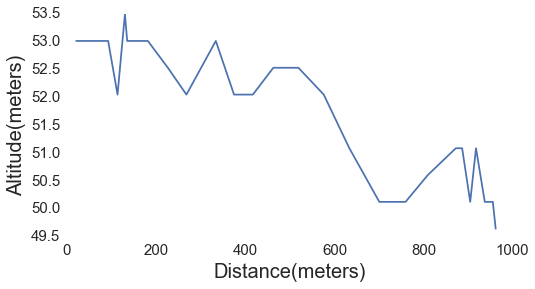

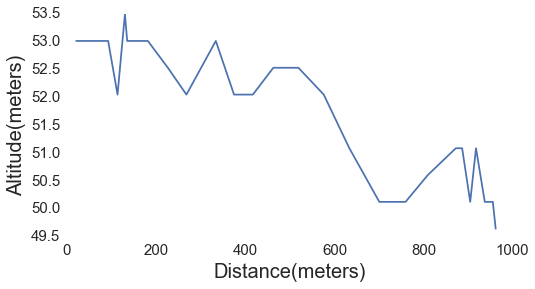

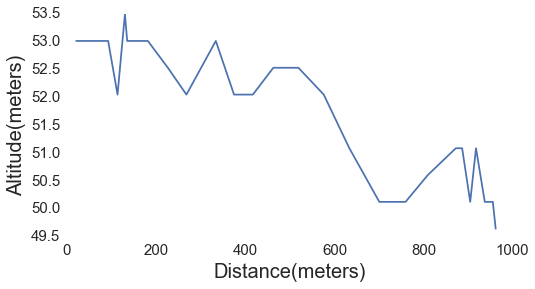

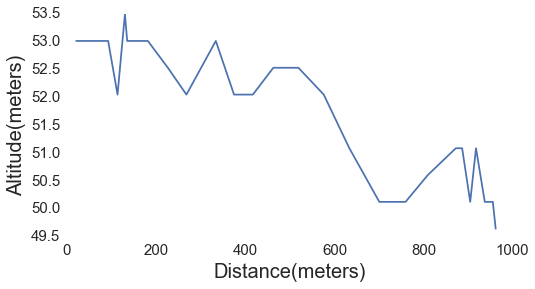

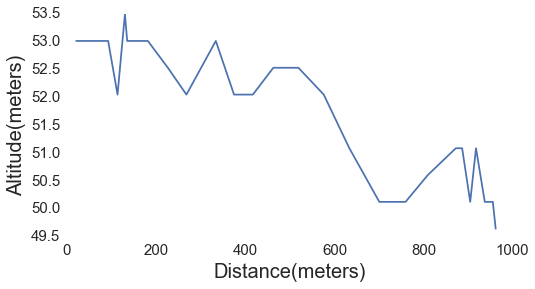

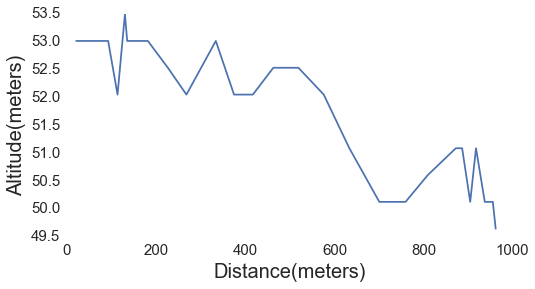

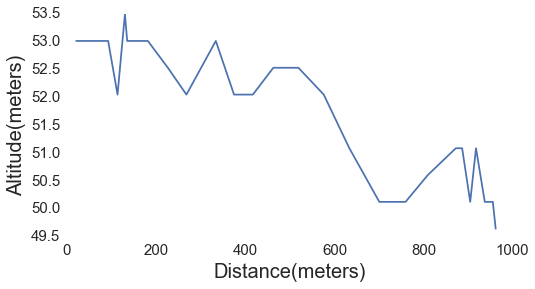

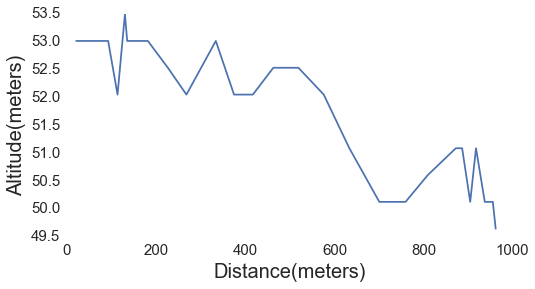

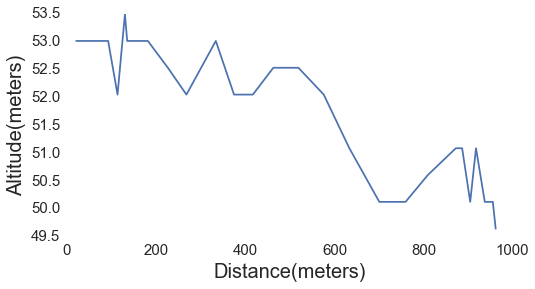

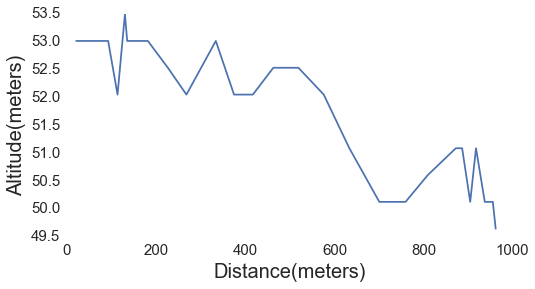

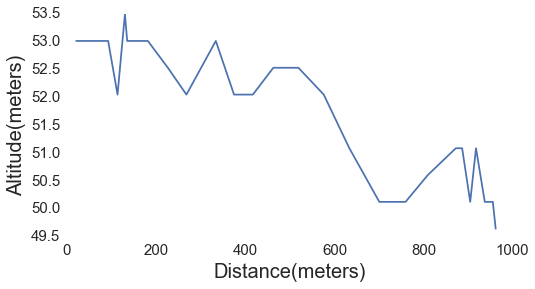

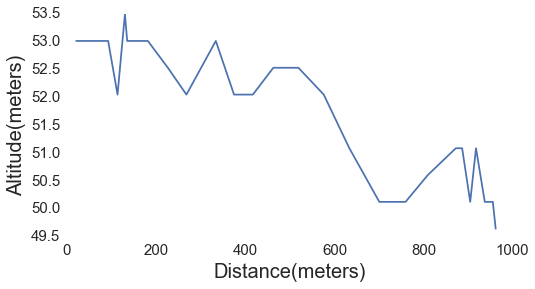

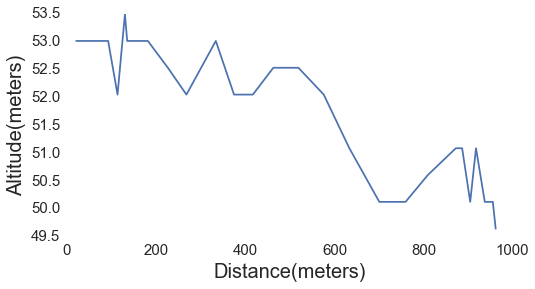

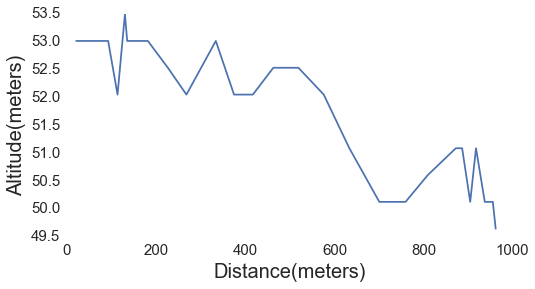

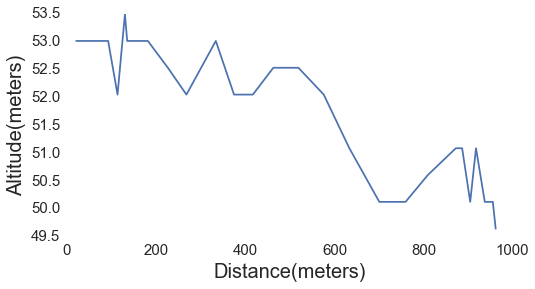

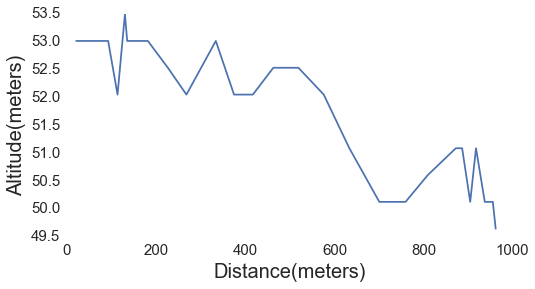

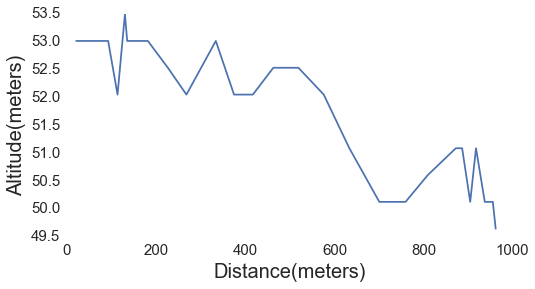

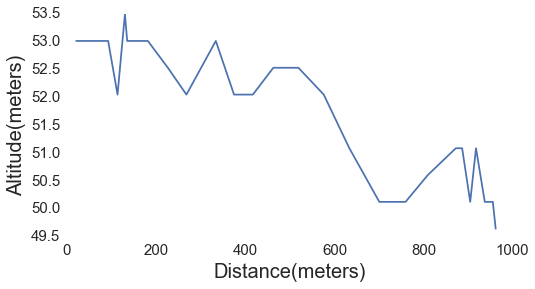

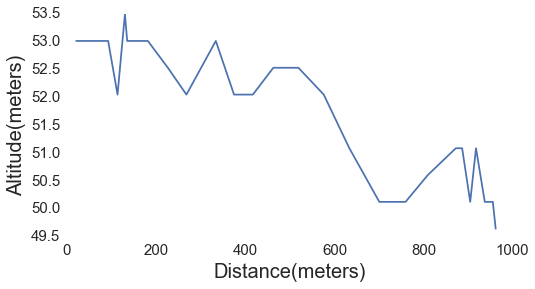

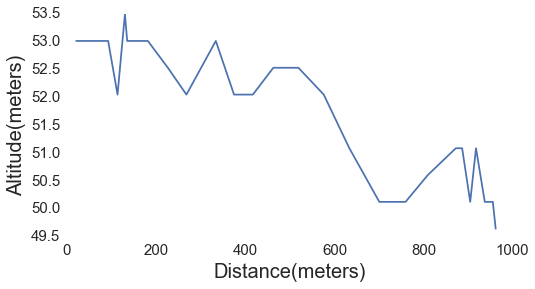

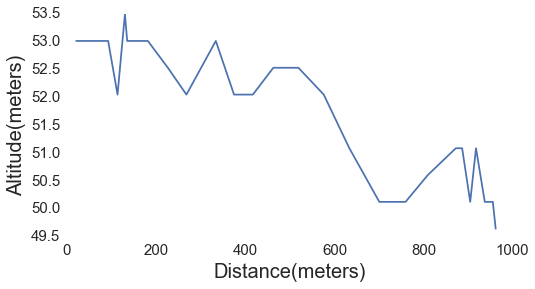

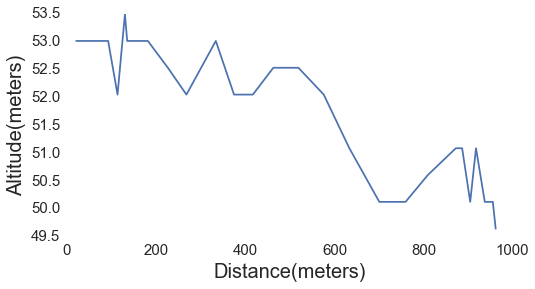

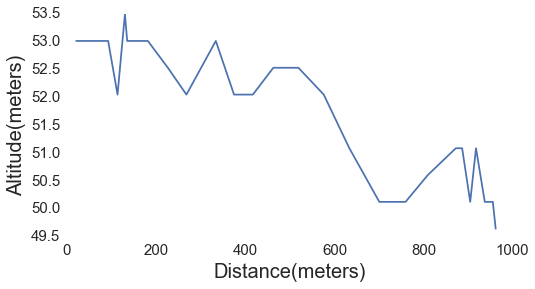

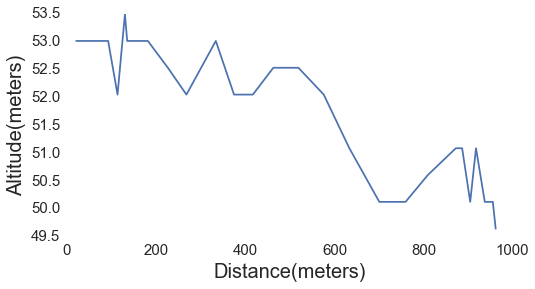

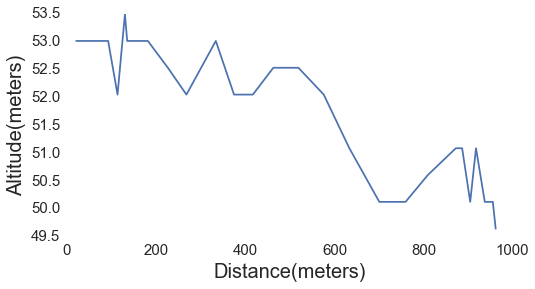

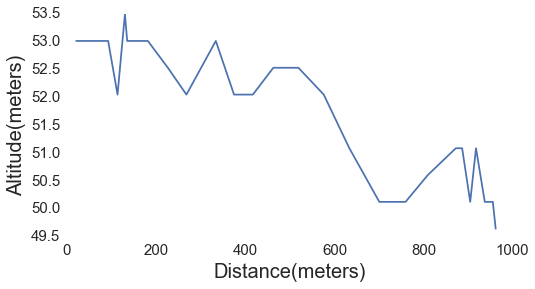

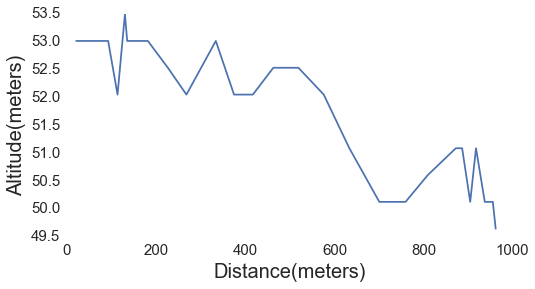

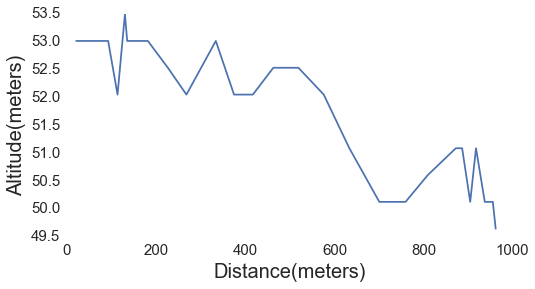

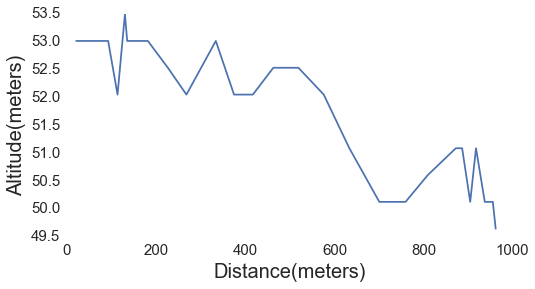

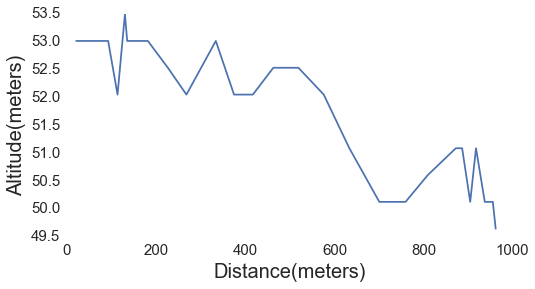

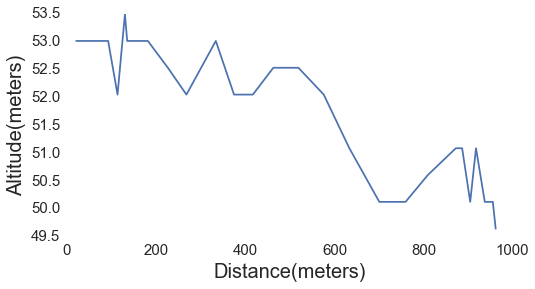

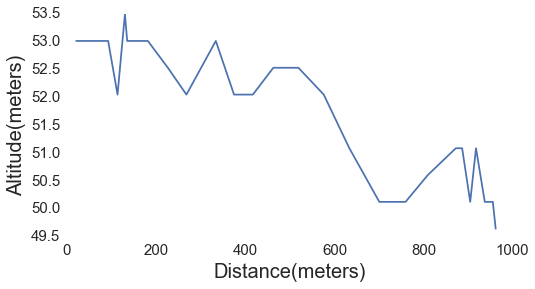

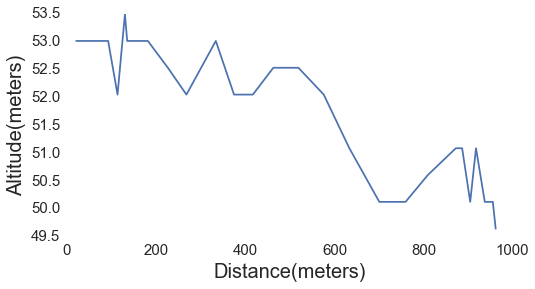

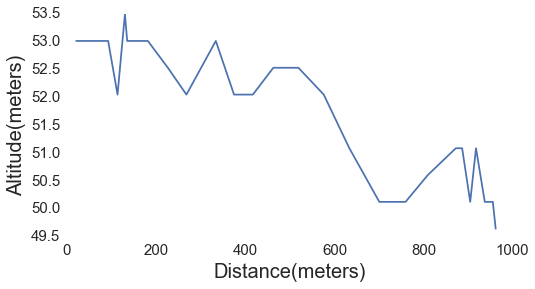

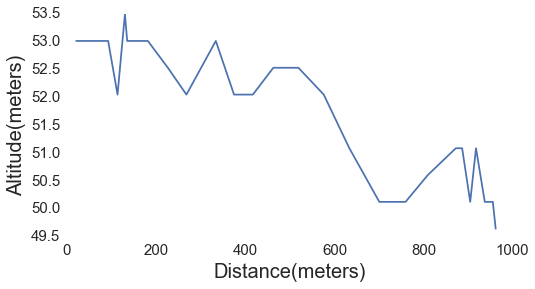

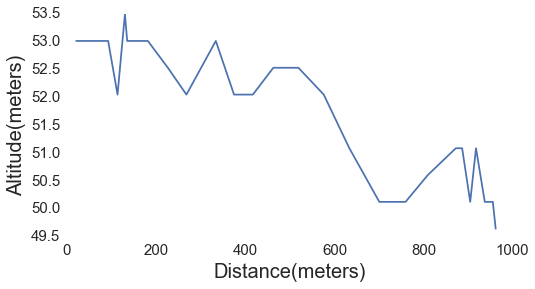

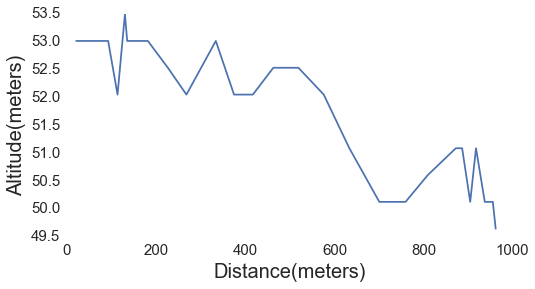

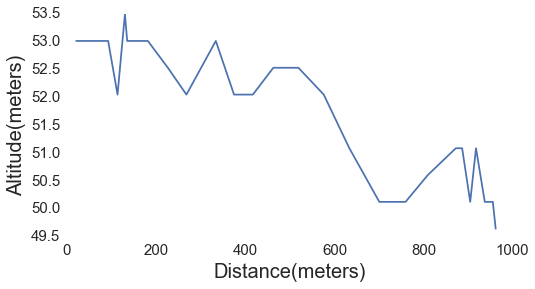

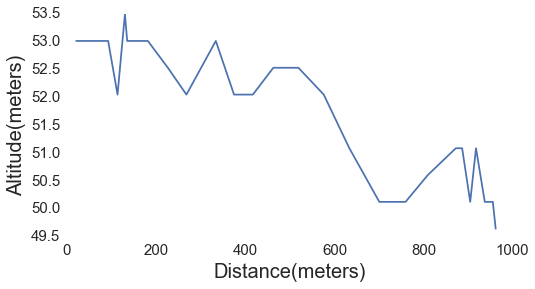

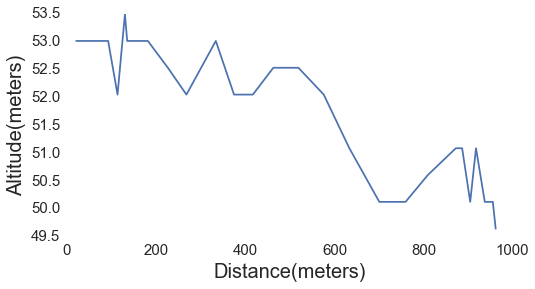

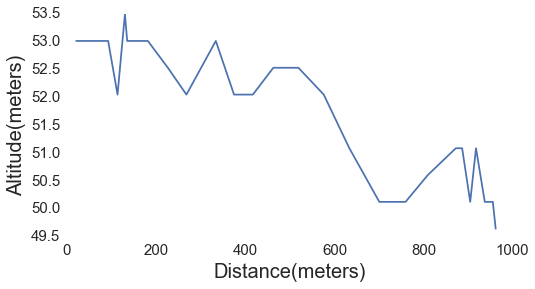

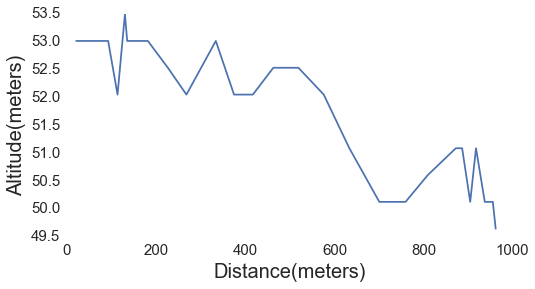

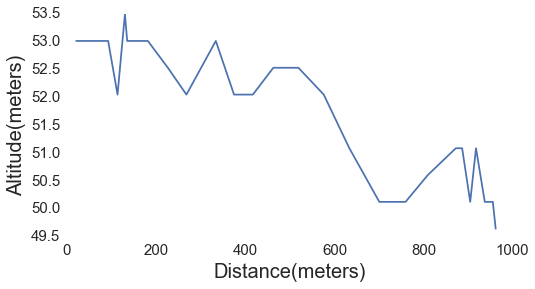

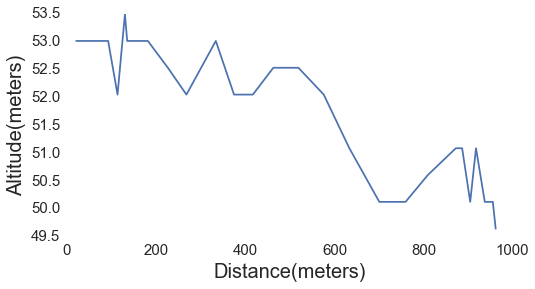

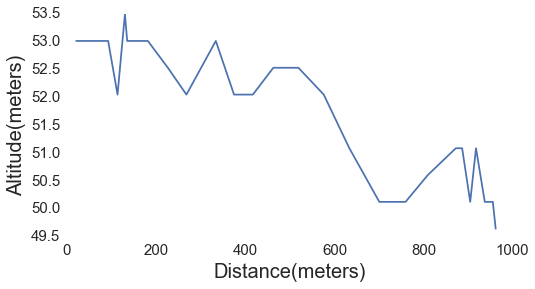

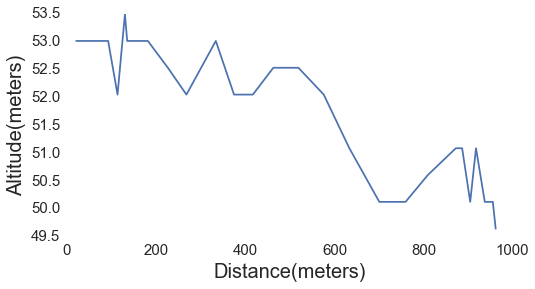

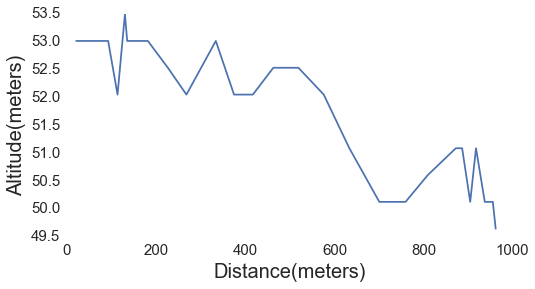

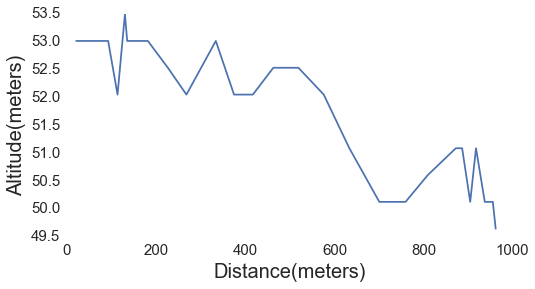

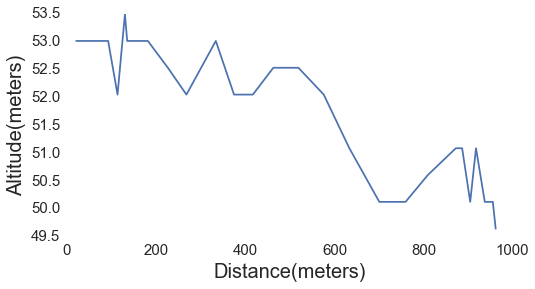

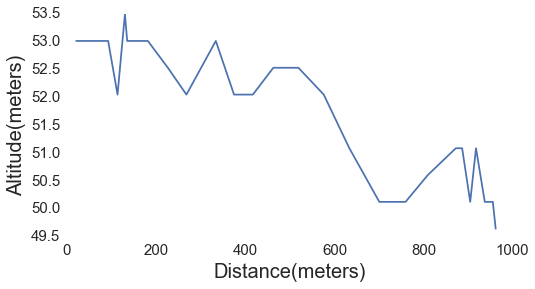

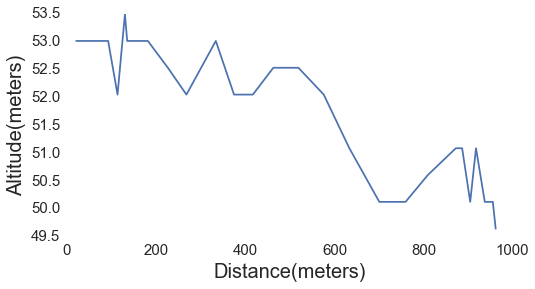

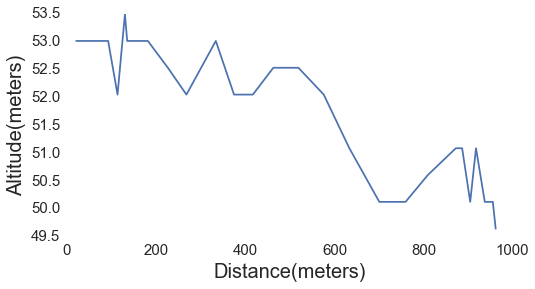

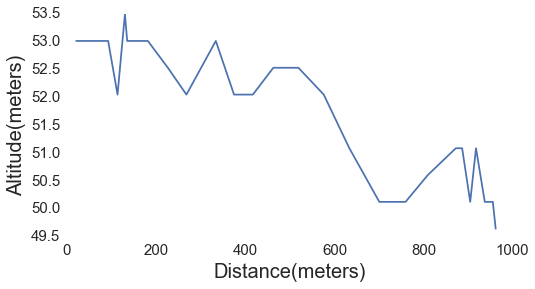

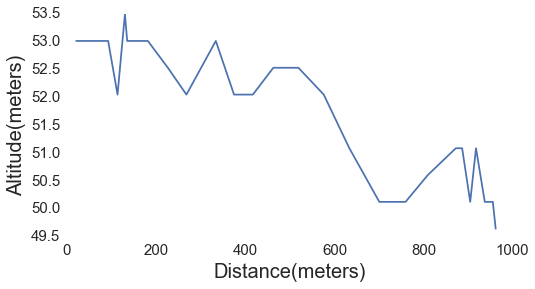

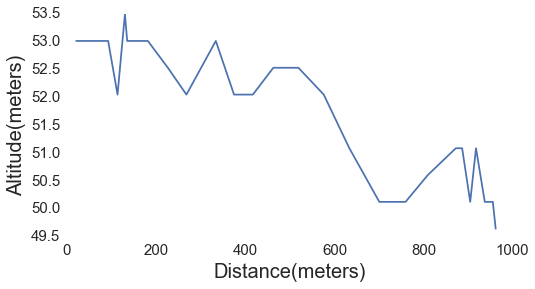

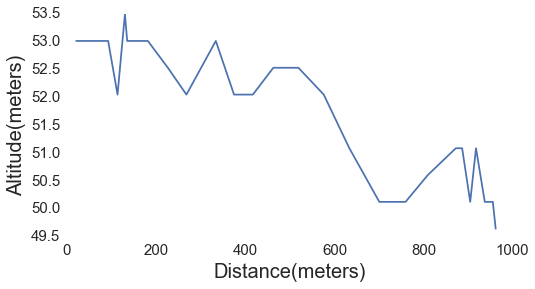

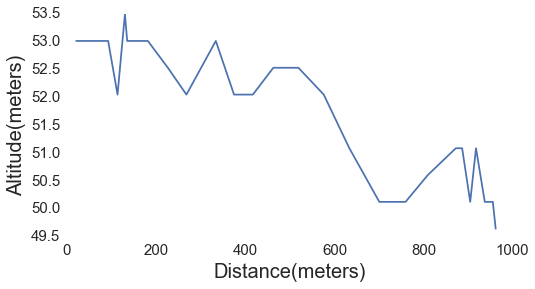

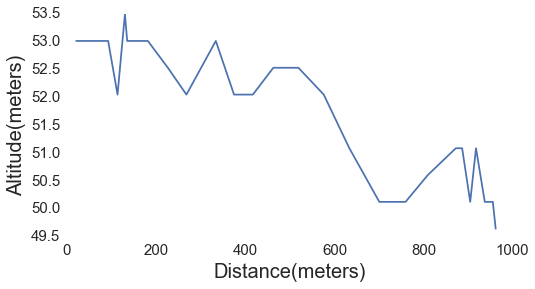

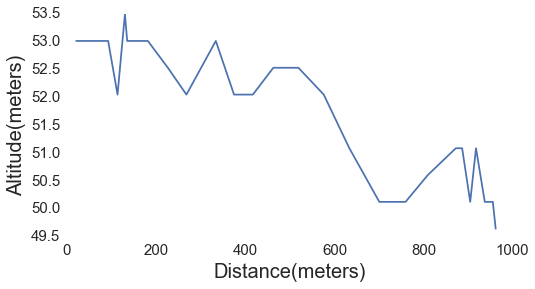

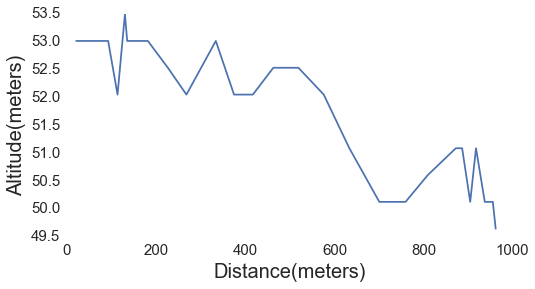

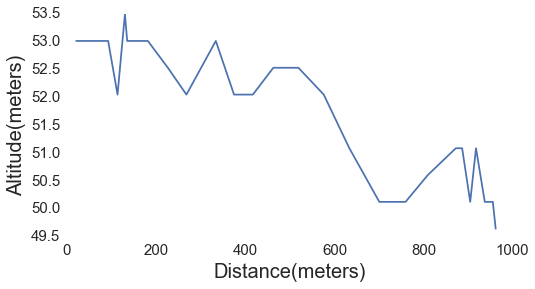

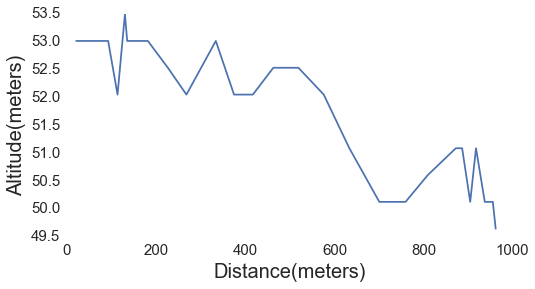

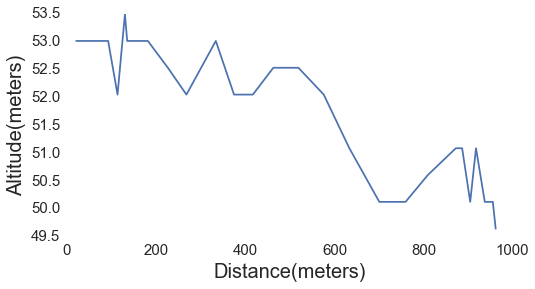

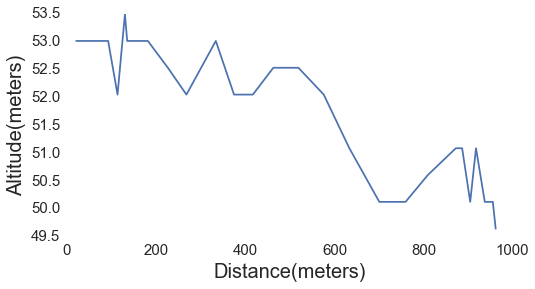

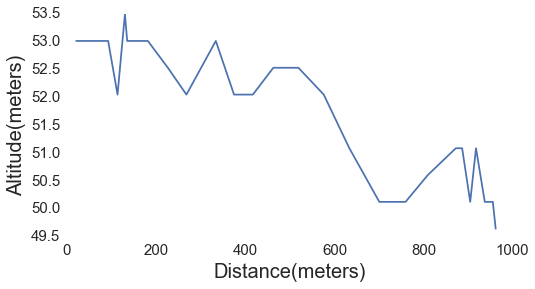

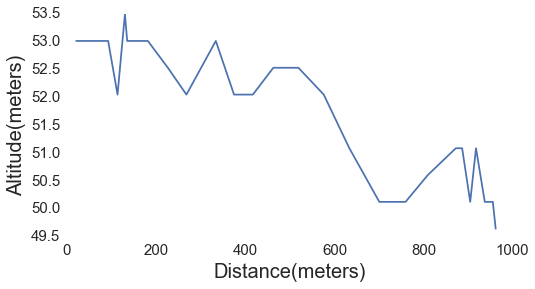

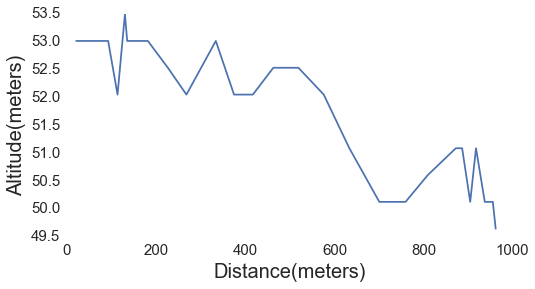

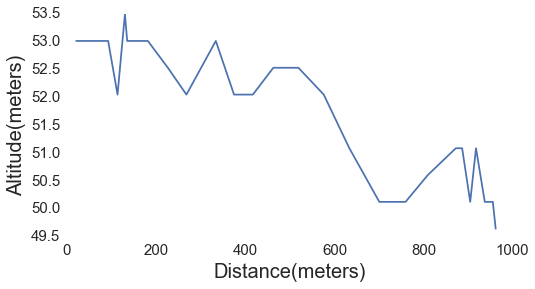

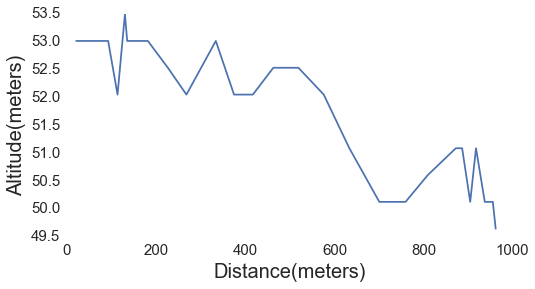

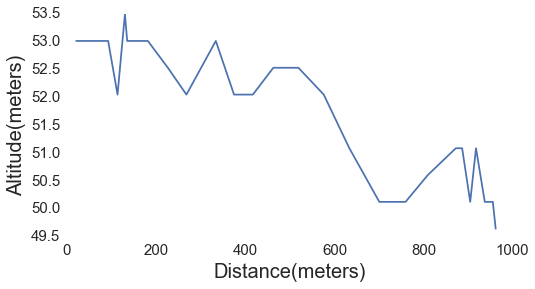

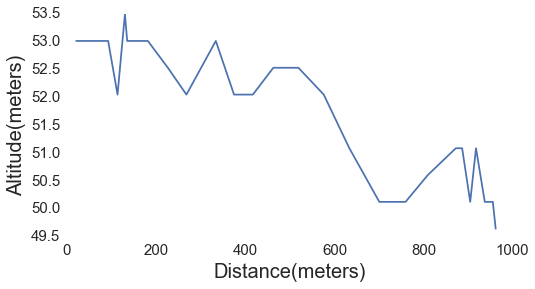

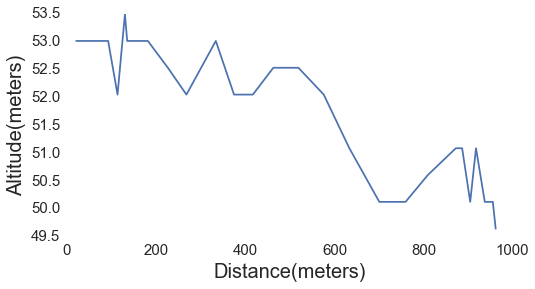

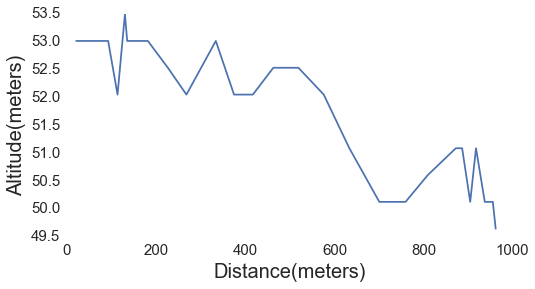

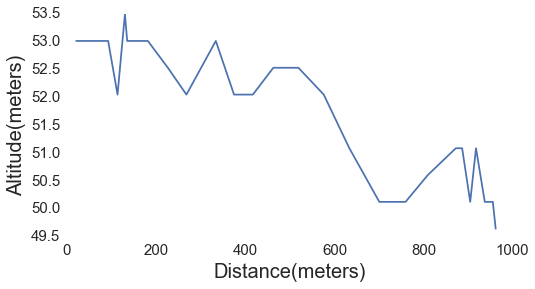

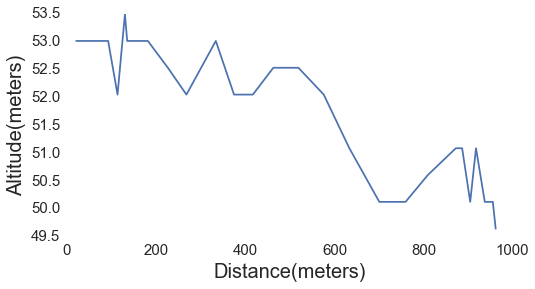

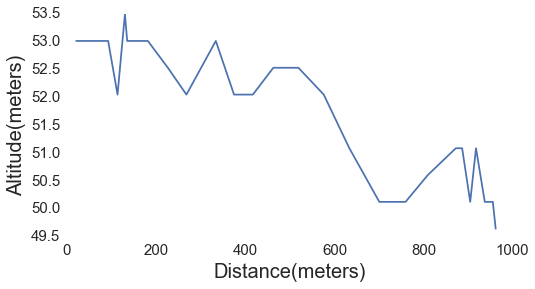

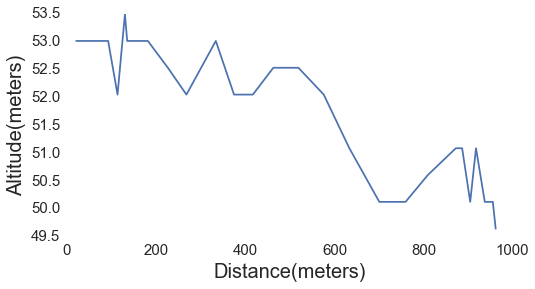

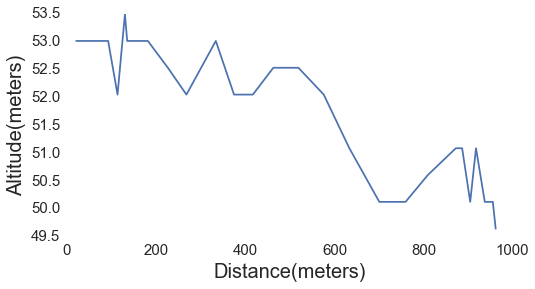

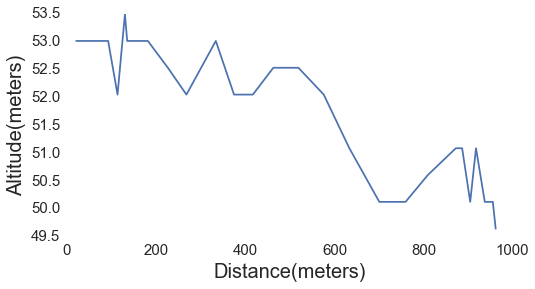

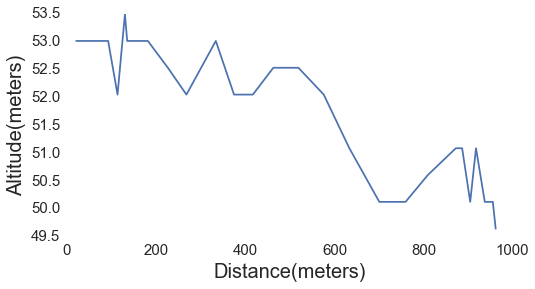

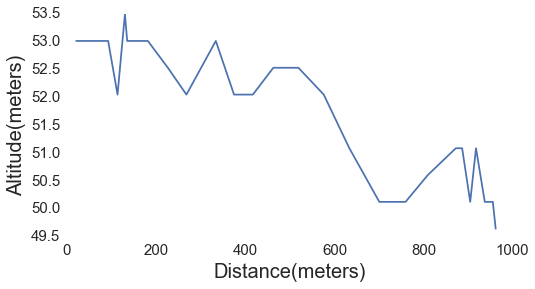

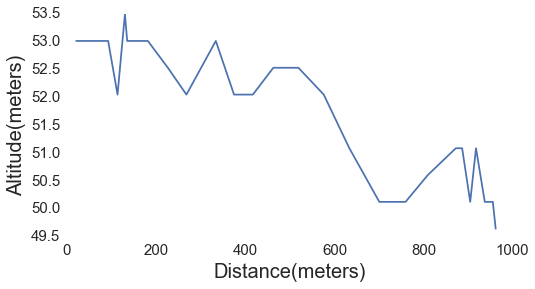

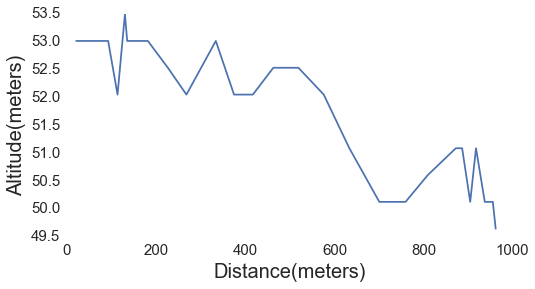

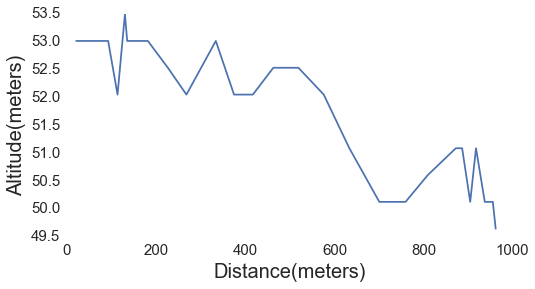

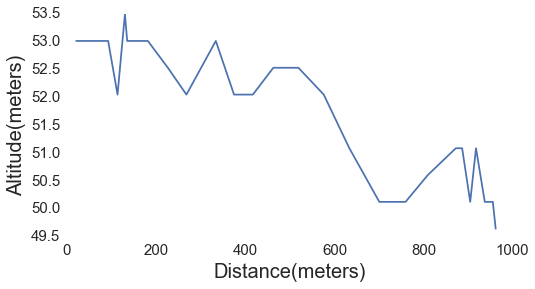

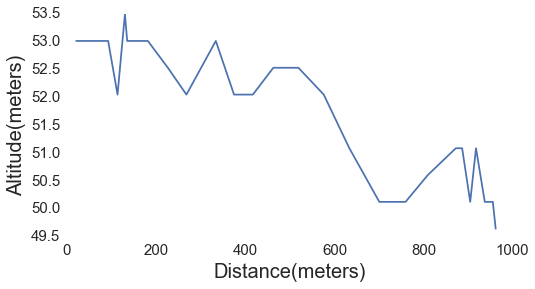

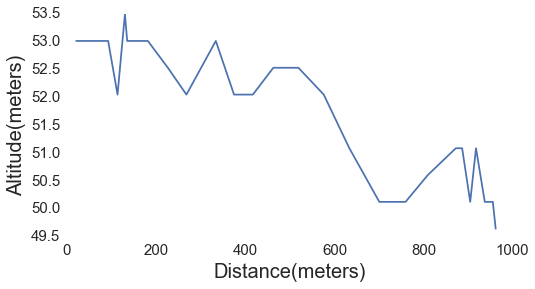

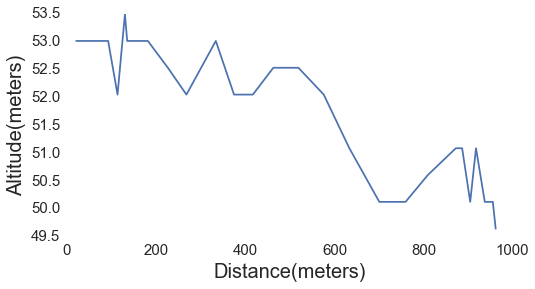

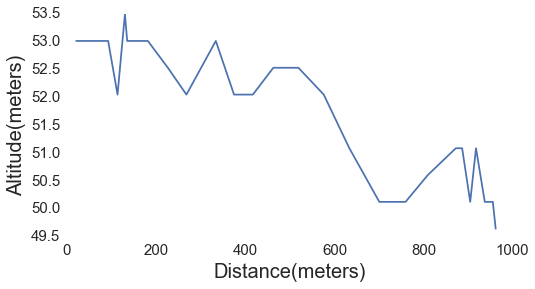

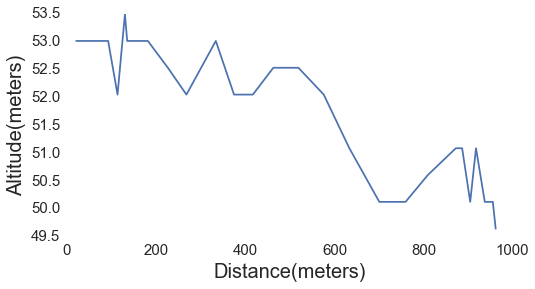

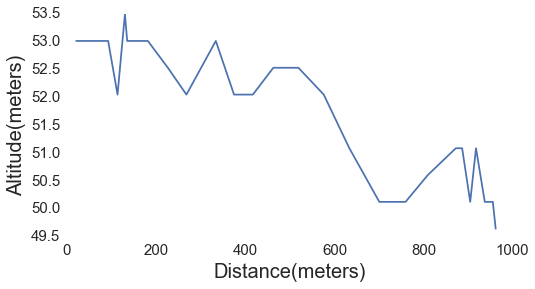

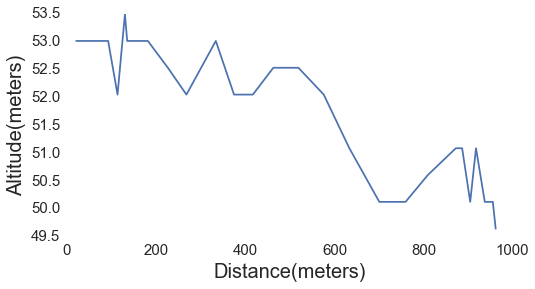

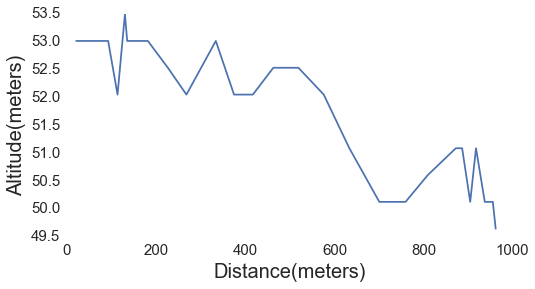

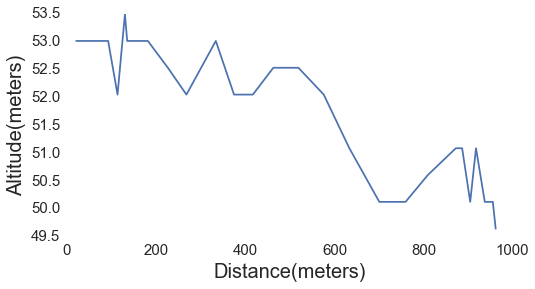

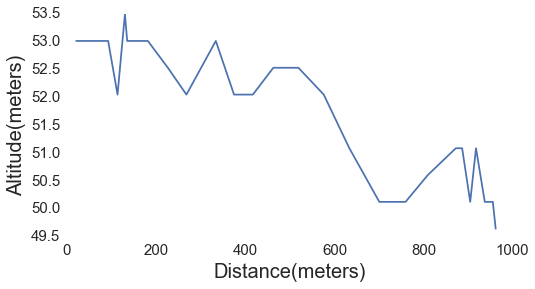

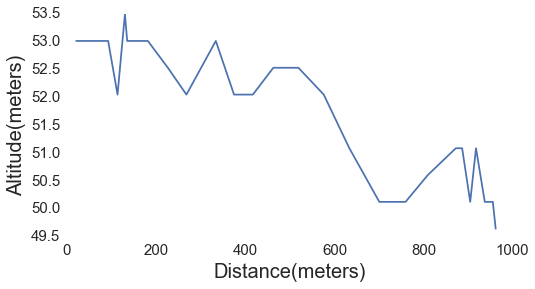

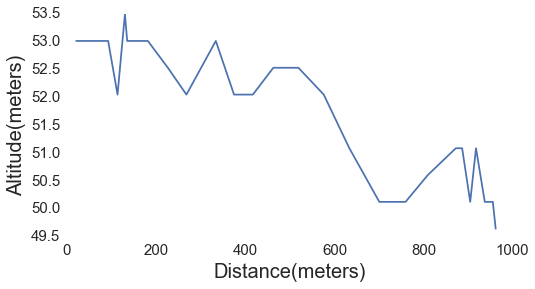

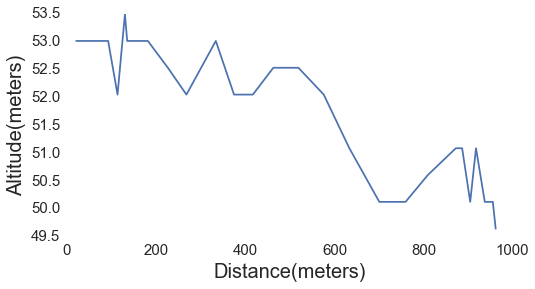

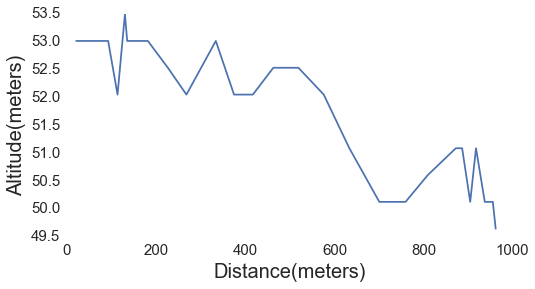

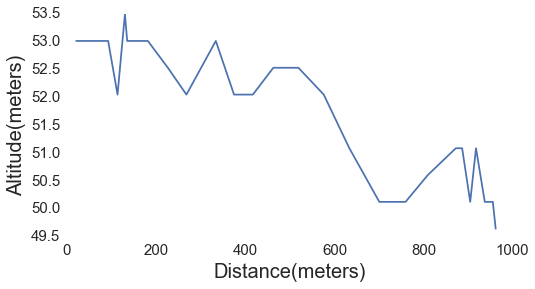

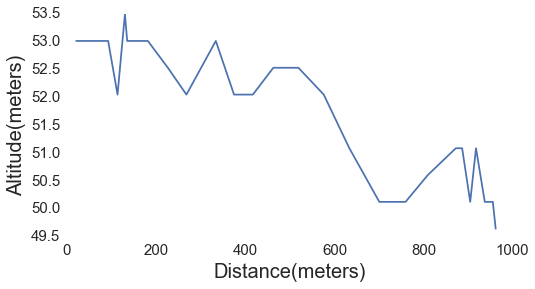

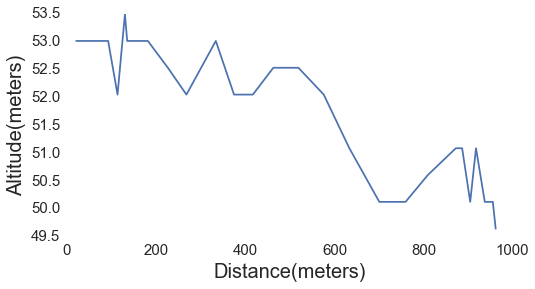

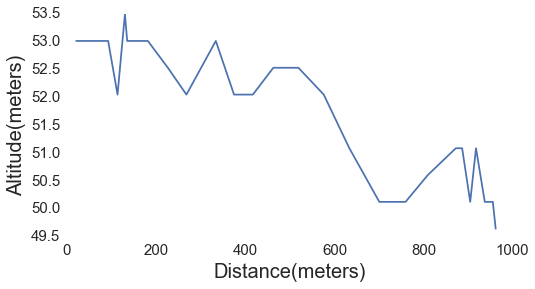

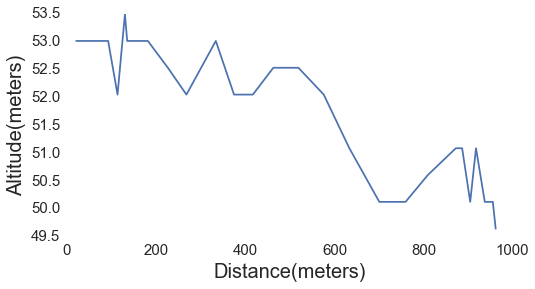

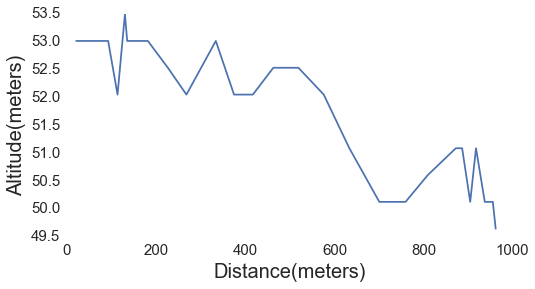

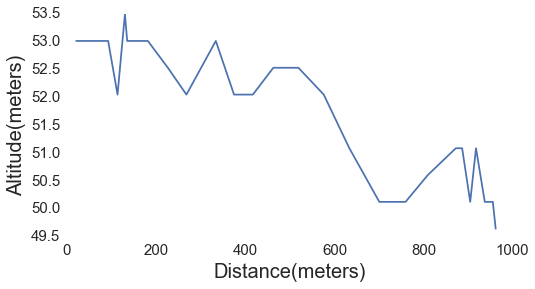

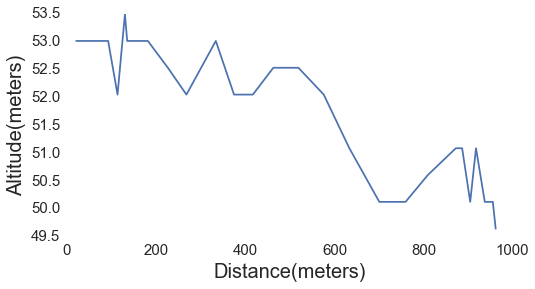

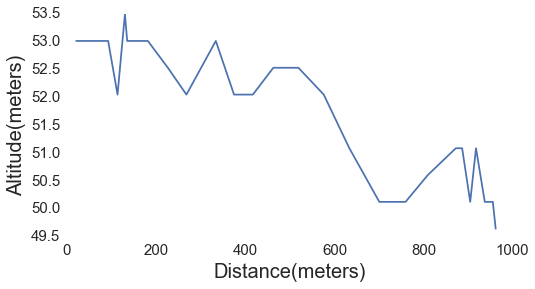

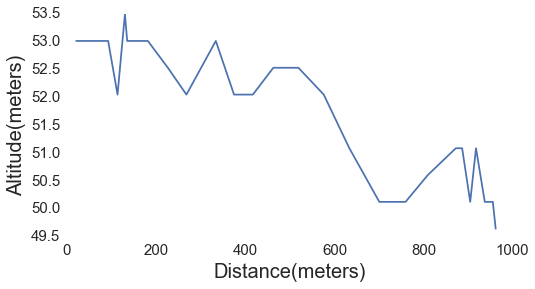

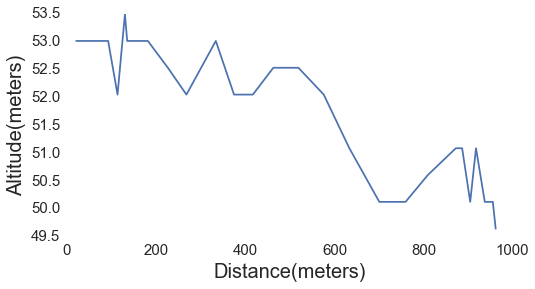

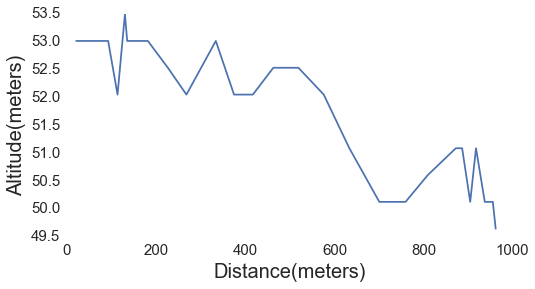

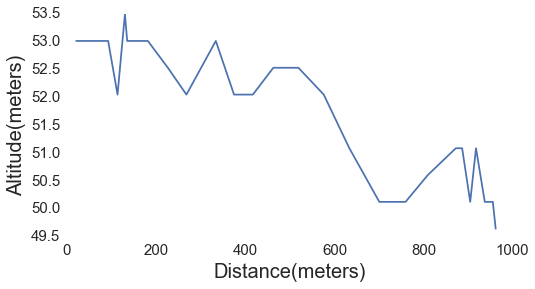

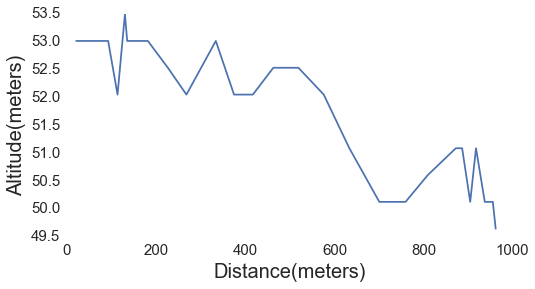

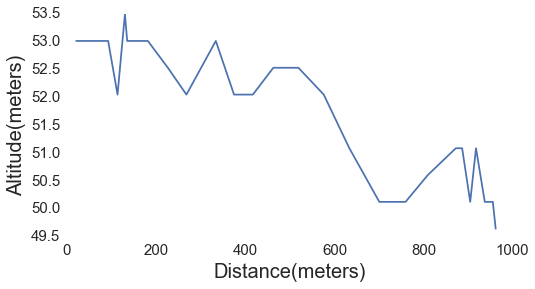

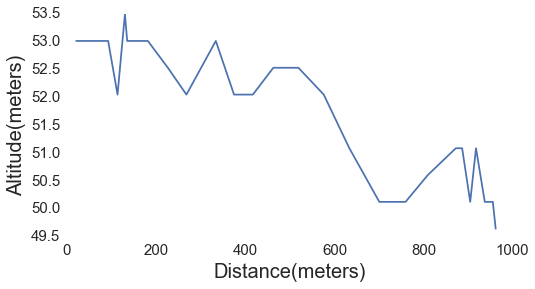

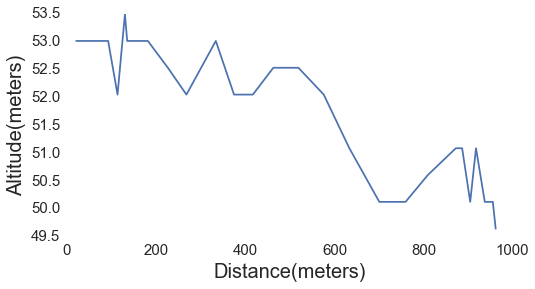

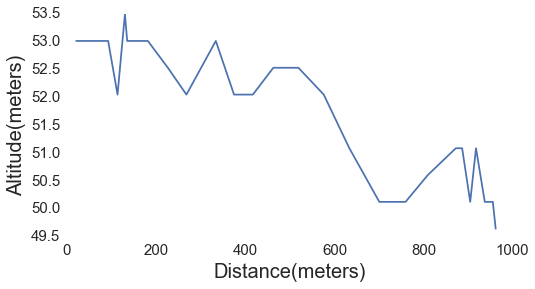

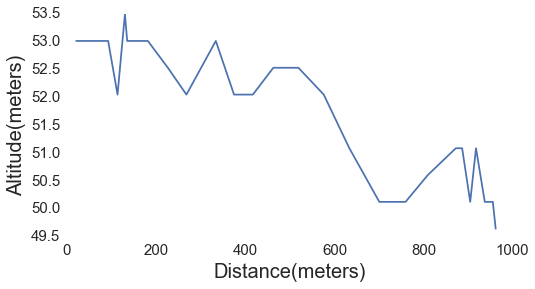

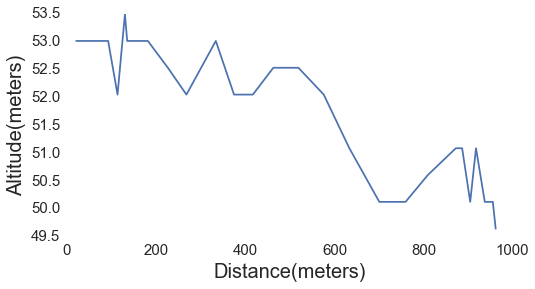

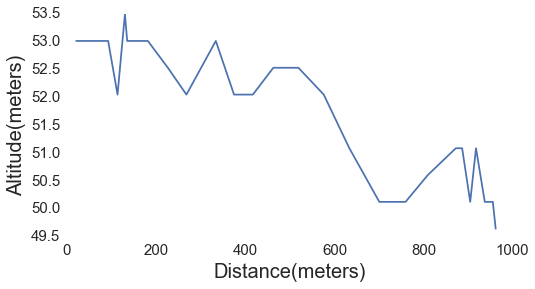

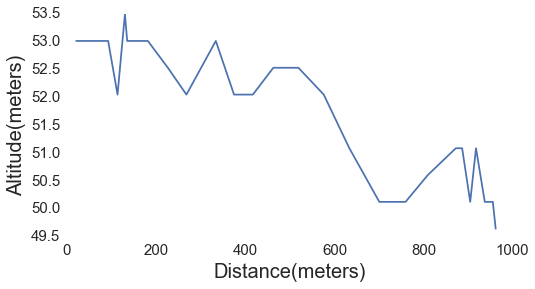

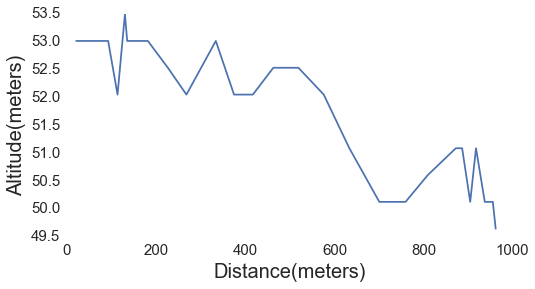

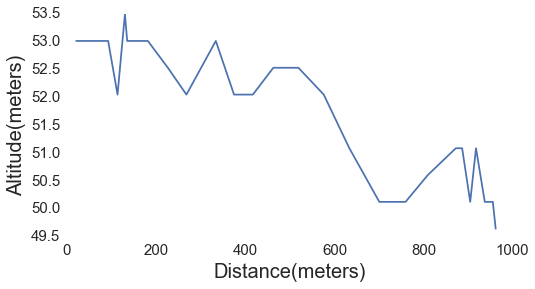

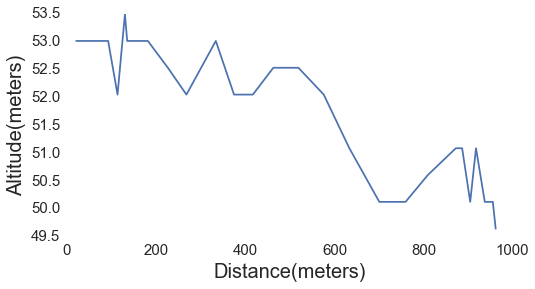

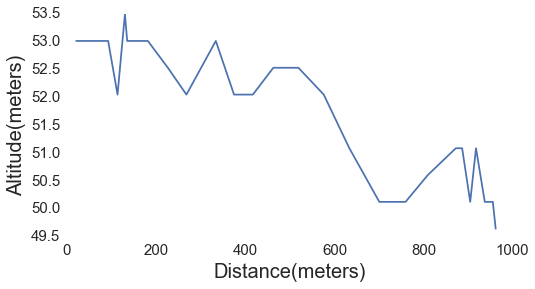

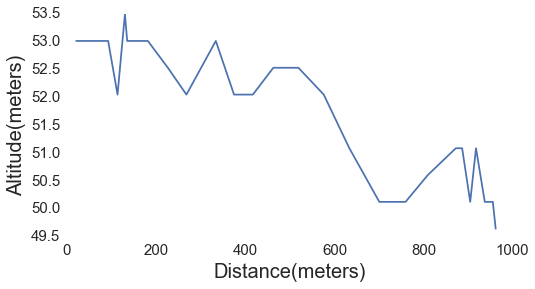

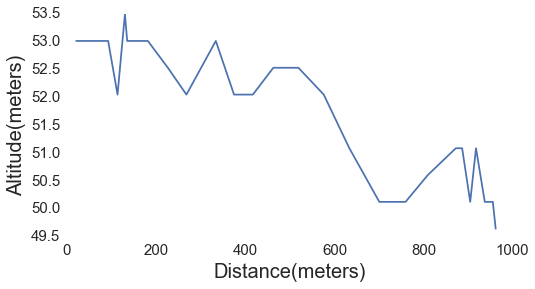

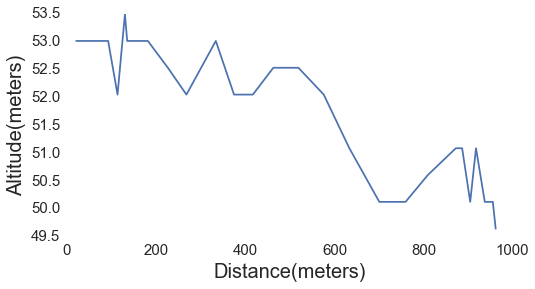

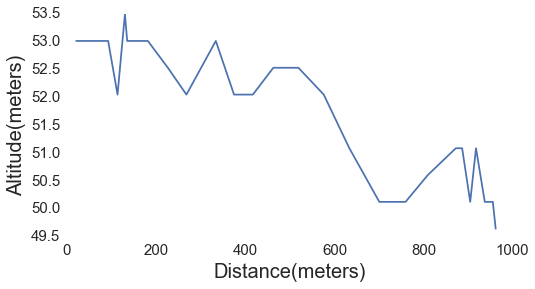

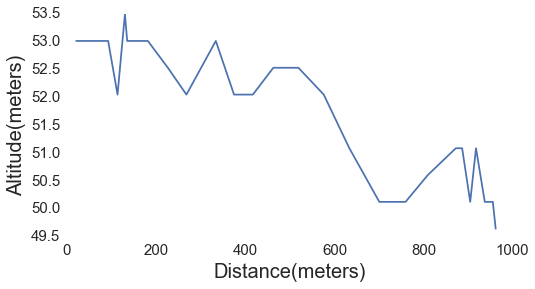

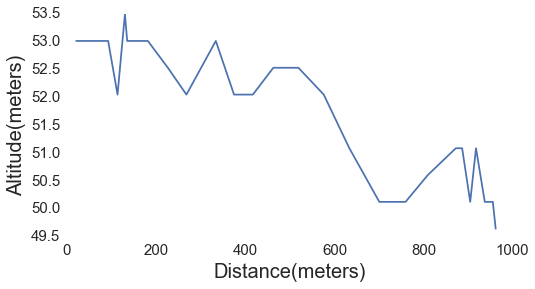

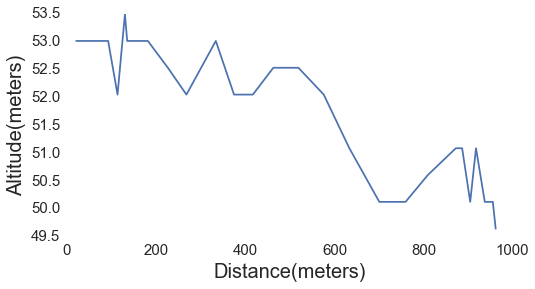

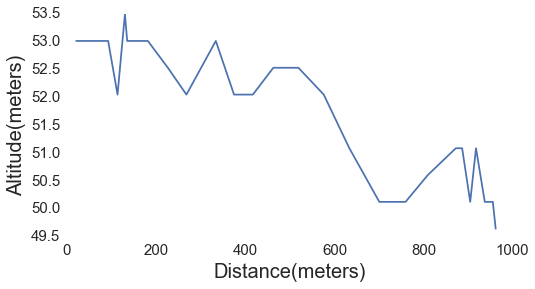

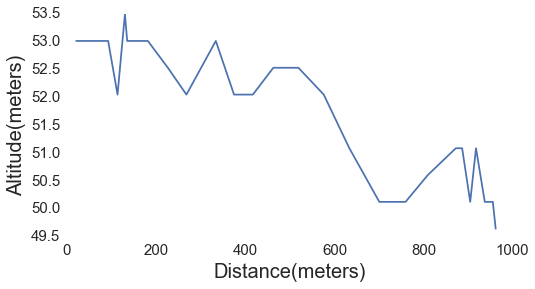

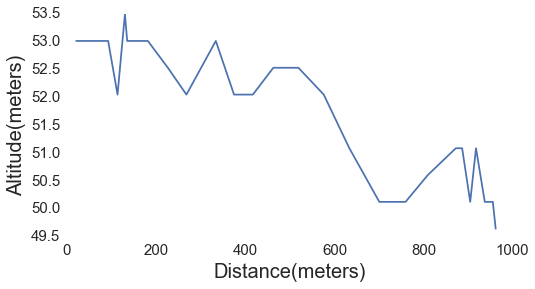

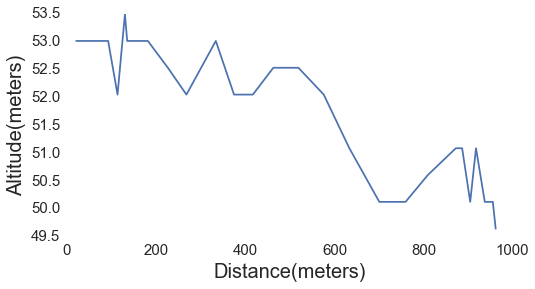

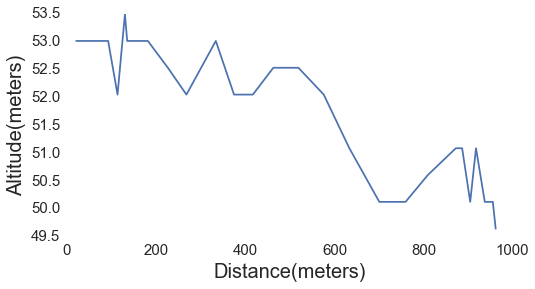

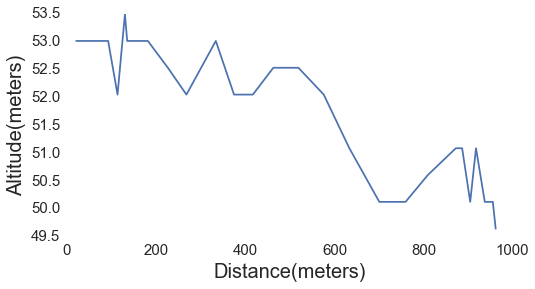

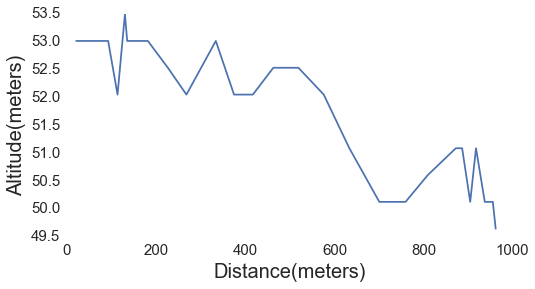

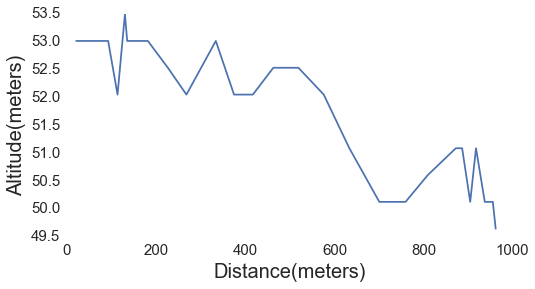

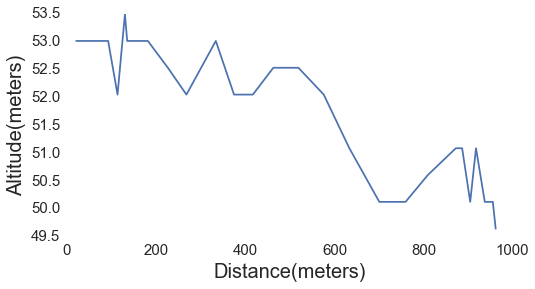

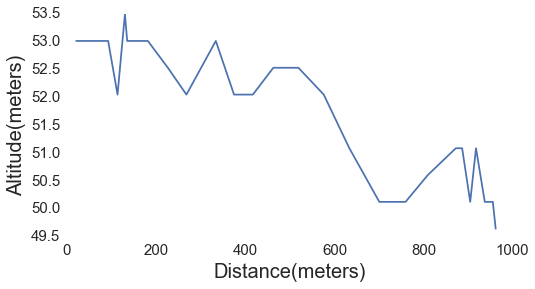

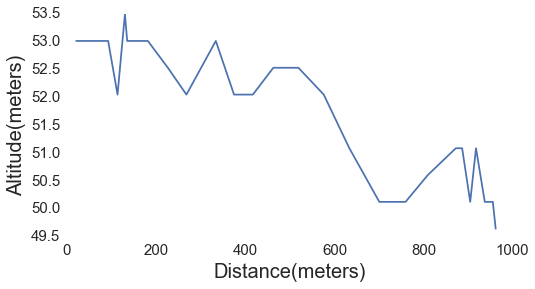

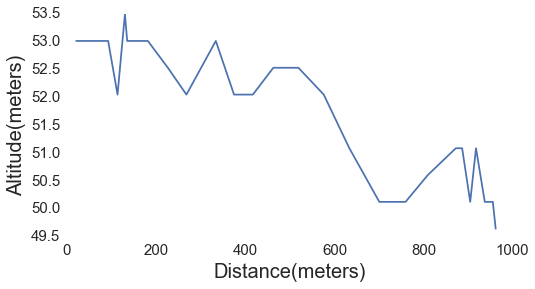

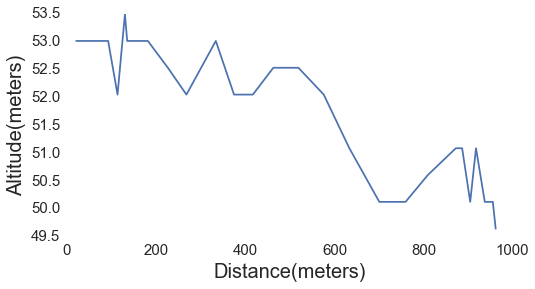

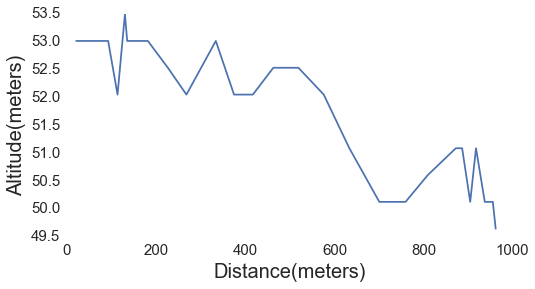

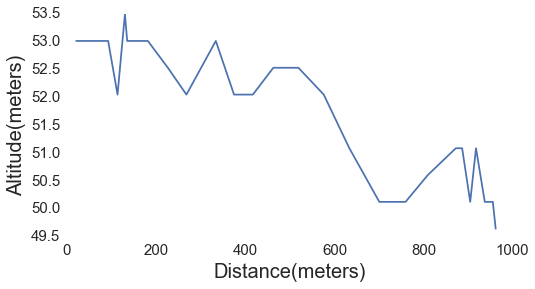

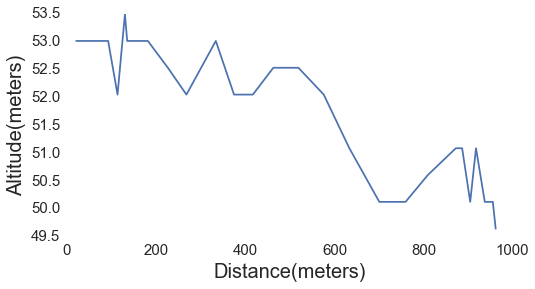

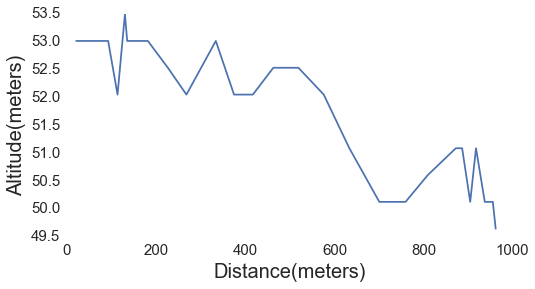

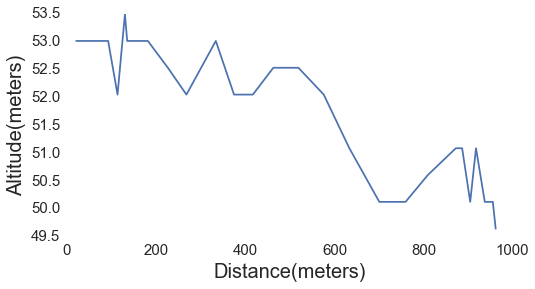

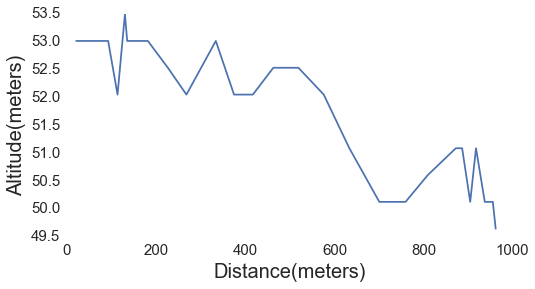

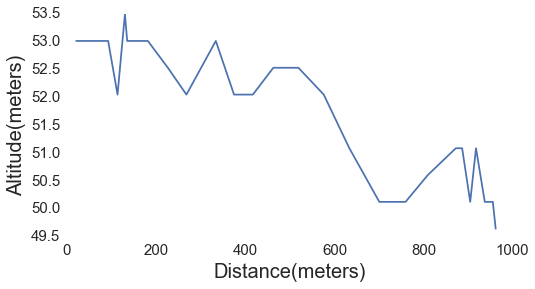

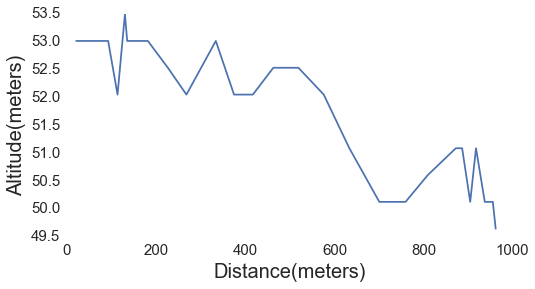

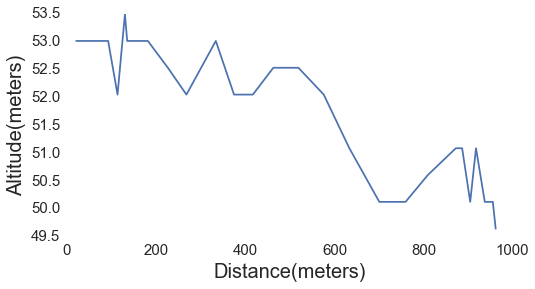

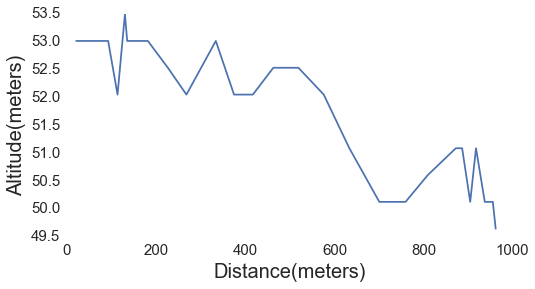

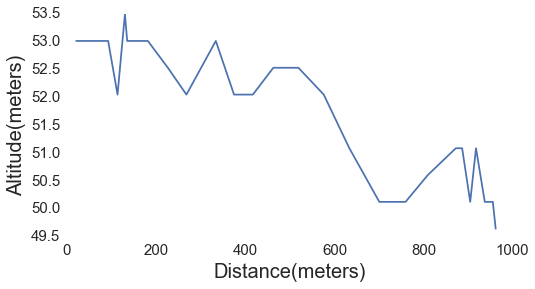

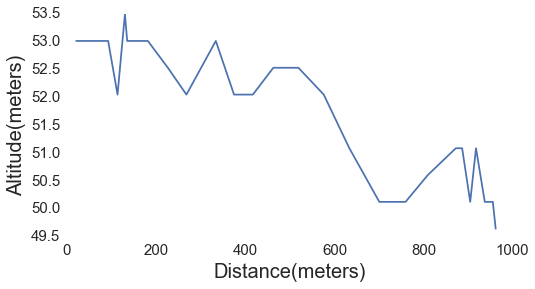

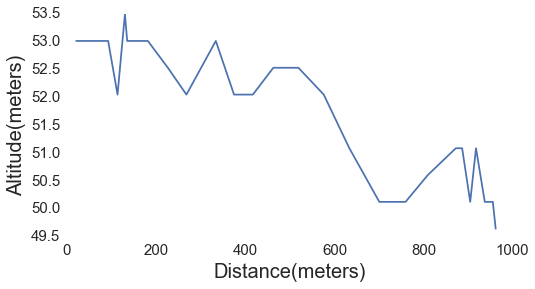

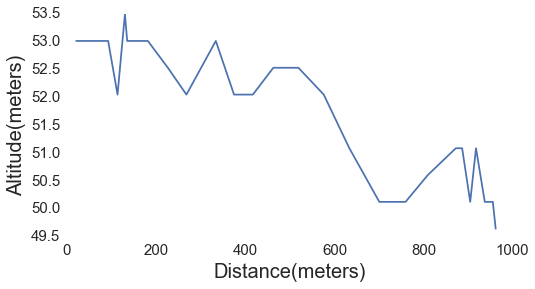

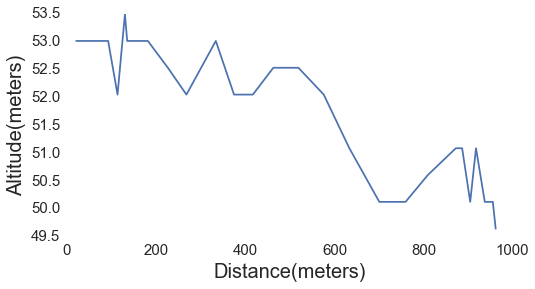

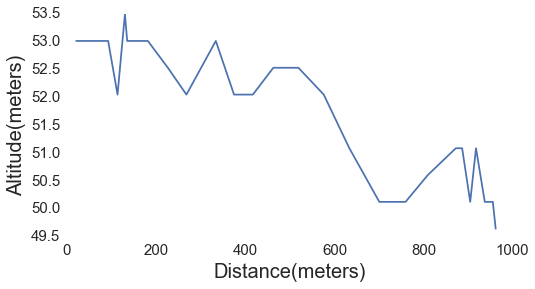

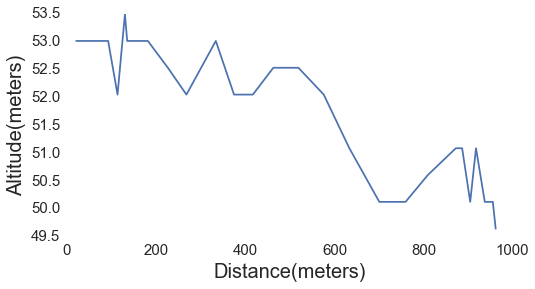

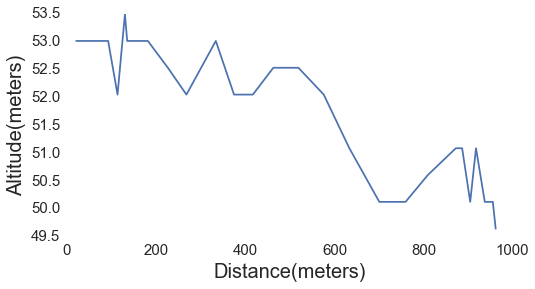

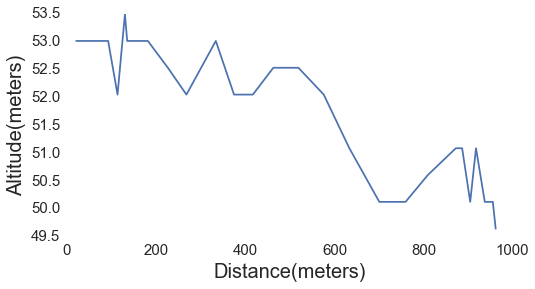

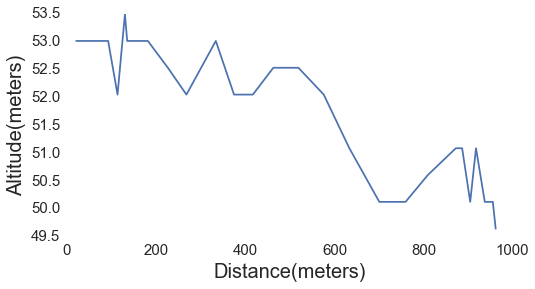

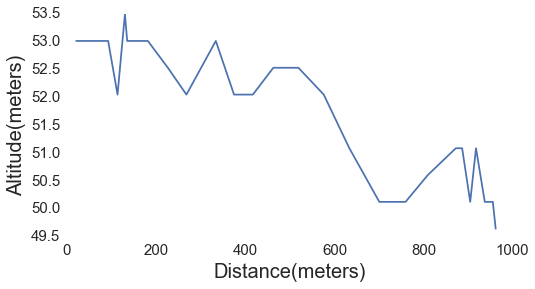

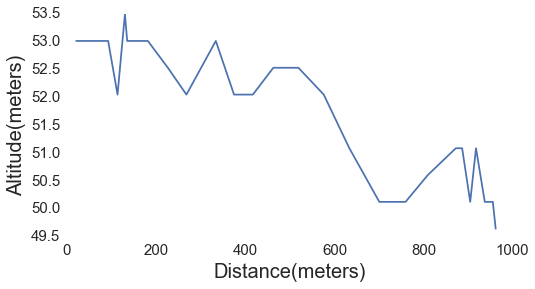

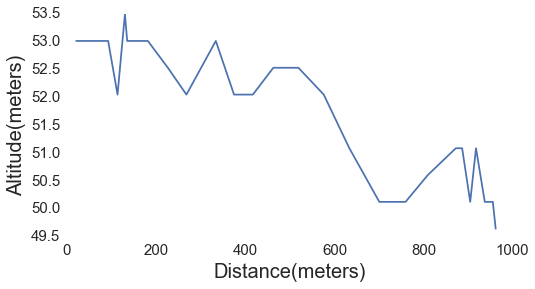

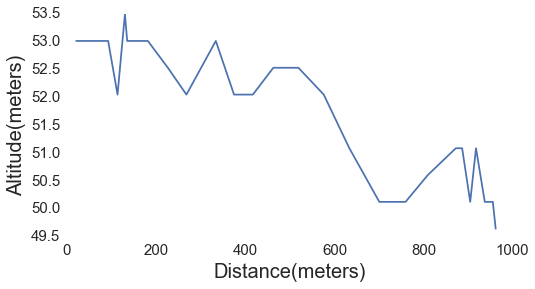

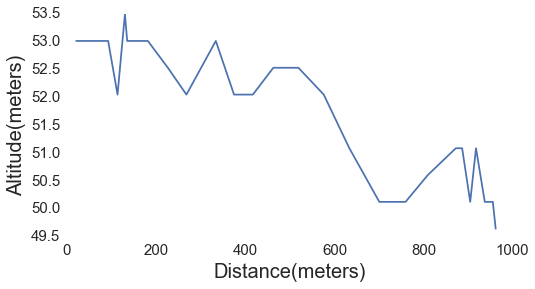

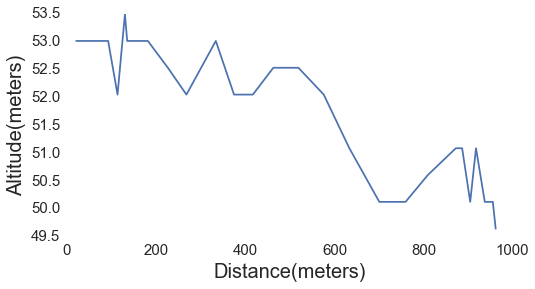

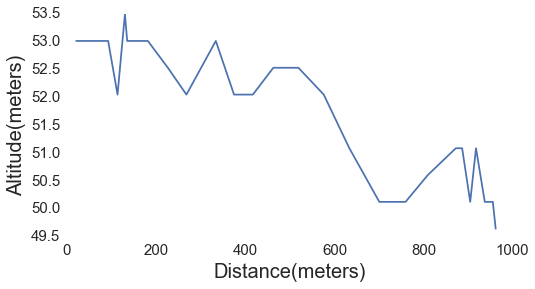

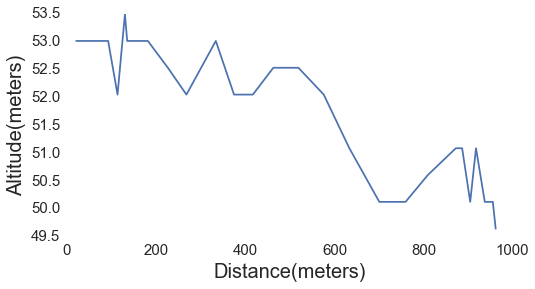

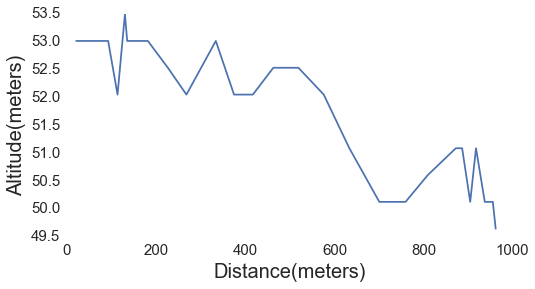

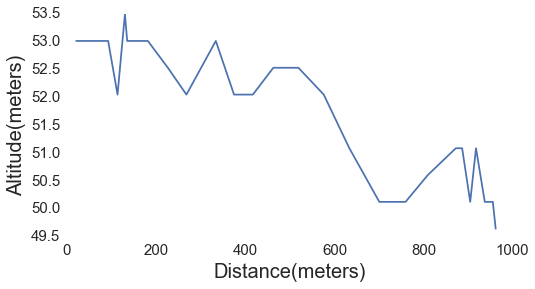

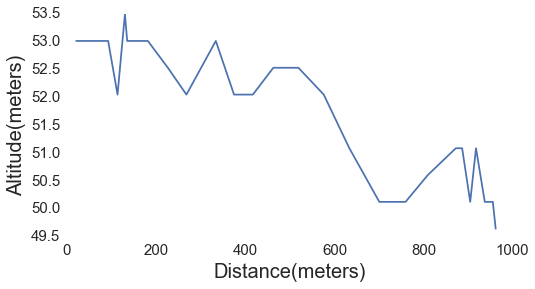

In [82]:
table = plot_maker()

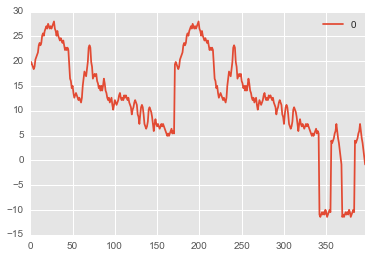

In [47]:
points2 = pandas.Series(points2)
points2 = pandas.DataFrame(points2)
points2.plot()

In [48]:
alts3 = next(altitude)
points3 = collapse_to_unique_points(alts3)

972
698


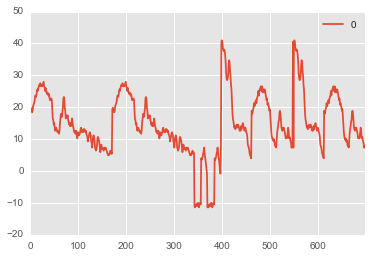

In [49]:
points3 = pandas.Series(points3)
points3 = pandas.DataFrame(points3)
points3.plot()
#plt.ylabel('measured altitude(meters)')
#plt.xlabel('indexed measurement')

In [9]:
#for row in df, while date.next == date.previous, append to list
#otherwise, stop and create new list 

def split_locs_by_date(df, datecolname):
    """ Create lists of lat and long from points visited on the same day (dates will be the same, times will vary).
    
    Note: assumes the df is sorted, with index reset, such that index follows the right order for sequential date values.
    
    sorted df (dataframe), datecolname (str) -> generator of lists of lat/long tuples
    
    """
    loc_list = []
    
    temp_date = df[datecolname][0].date()
    for item in df.index.values:  
        if df[datecolname][item].date() == temp_date:
            loc_list.append((df['Lat'][item],df['Long'][item]))
        
        else:
            temp_date = df[datecolname][item].date()
            yield loc_list
    

In [10]:
#test split_by_date
loc_1 = split_locs_by_date(df, 'zoned')

In [11]:
points = next(loc_1)

In [12]:
print points, len(path)

[(37.394300000000001, -122.07689999999999), (37.394300000000001, -122.0771), (37.394399999999997, -122.0774), (37.3947, -122.07810000000001), (37.394799999999996, -122.0782), (37.395000000000003, -122.0782), (37.395299999999999, -122.0779), (37.395299999999999, -122.0779), (37.395400000000002, -122.07769999999999), (37.395400000000002, -122.0776), (37.395099999999999, -122.07700000000001), (37.3949, -122.07640000000001), (37.3947, -122.0758), (37.394199999999998, -122.0746), (37.393799999999999, -122.0736), (37.3934, -122.0727), (37.393000000000001, -122.07170000000001), (37.392800000000001, -122.0711), (37.392400000000002, -122.0702), (37.392099999999999, -122.0697), (37.392099999999999, -122.06959999999999), (37.3919, -122.06910000000001), (37.391599999999997, -122.0684), (37.391399999999997, -122.0677), (37.391199999999998, -122.0673), (37.390900000000002, -122.0665), (37.390500000000003, -122.0656), (37.390000000000001, -122.0643), (37.389600000000002, -122.06319999999999), (37.389

NameError: name 'path' is not defined

In [97]:
locations = [(row[1],row[2]) for row in df[['Lat','Long']].itertuples()]
print('\n'.join(str(x) for x in [locations[0],locations[1]]))

(37.394300000000001, -122.07689999999999)
(37.394300000000001, -122.0771)


In [ ]:
#want to extract lat and long from df based on date and feed it in as a path 


In [141]:
#get elevations back and plot them
elevations = [5.627086639404297, 5.839840412139893, 5.483985424041748, 5.309235572814941, 5.852761745452881, 5.960859775543213, 5.806560516357422, 6.369852542877197, 6.051360130310059, 7.211959362030029, 7.365567207336426, 8.226292610168457, 6.00233268737793, 5.292089939117432, 5.007282257080078, 5.485466957092285, 6.159402370452881, 6.032011985778809, 5.825675964355469, 6.803745269775391, 6.615157127380371, 7.041442394256592, 7.26495885848999, 8.15757942199707, 8.358736991882324, 8.171339988708496, 9.118271827697754, 9.259295463562012, 9.994961738586426, 9.843290328979492, 10.59953498840332, 11.63686466217041, 12.35517120361328, 12.22323799133301, 13.69894313812256, 15.62654495239258, 15.67187404632568, 17.01805877685547, 17.14420890808105, 17.4635181427002, 19.87927436828613, 19.89750289916992, 21.23011016845703, 21.92111968994141, 22.83876800537109, 24.1338062286377, 24.60493278503418, 23.86082649230957, 22.81315612792969, 23.10221862792969, 22.74290657043457, 22.27962875366211, 22.03162384033203, 22.9021110534668, 24.29611206054688, 25.30944633483887, 27.05757331848145, 27.76638793945312, 28.46392059326172, 28.62152481079102, 28.50705528259277, 28.08891868591309]
elevated = pandas.Series(elevations)

In [142]:
df = pandas.DataFrame(elevated)

(array([  5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 6 Text yticklabel objects>)

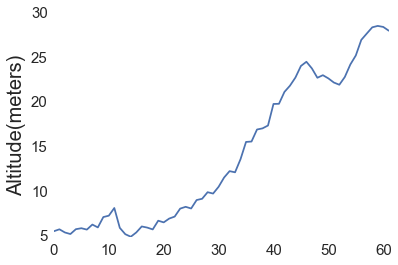

In [143]:
ax = df.plot(legend=False)
ax.set_ylabel('Altitude(meters)', fontsize=20)
#ax.set_xlabel('Distance(meters)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [45]:
#would be nicer to be able to plot this over time, but it's pretty consistent with what cycleroute.org gave 
#for comparison, the Eiffel Tower is 300 m tall, potrero hill is 46 m (150 ft) 

(array([  0.,   5.,  10.,  15.,  20.,  25.,  30.]),
 <a list of 7 Text yticklabel objects>)

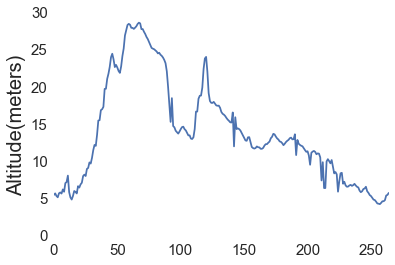

In [145]:
ele2=[28.08170700073242, 27.94421195983887, 28.10497665405273, 28.29936790466309, 28.60774993896484, 28.78005599975586, 28.68700981140137, 27.90944862365723, 27.9266529083252, 27.56032943725586, 27.25487327575684, 26.85952186584473, 26.57603645324707, 26.19034576416016, 25.80401992797852, 25.38783836364746, 25.28845405578613, 25.21034812927246, 25.05902290344238, 24.9037971496582, 24.64801788330078, 24.74091339111328, 24.47681427001953, 24.3245792388916, 24.09706497192383, 23.77349853515625, 23.33495712280273, 22.24639320373535, 20.17004013061523, 17.80467796325684, 15.44187259674072, 18.63554382324219, 14.88895511627197, 14.71258354187012, 14.255690574646, 14.07004642486572, 13.86791133880615, 14.14136981964111, 14.47133445739746, 14.74272537231445, 14.80256366729736, 14.471116065979, 14.29596710205078, 13.9620246887207, 13.62836933135986, 13.63751220703125, 13.20072841644287, 13.14438915252686, 13.37343120574951, 14.48258495330811, 16.82987403869629]
ele3 = [16.82987403869629, 18.55566215515137, 18.9598217010498, 18.98641395568848, 20.05703163146973, 22.54707145690918, 23.96240615844727, 24.18024826049805, 22.18376541137695, 19.31110954284668, 18.25616645812988, 18.00452613830566, 17.99230194091797, 18.13630104064941, 17.88492774963379, 17.65925025939941, 17.61457443237305, 17.62855529785156, 17.34478187561035, 16.78891754150391, 16.53693008422852, 16.42161750793457, 16.24383735656738, 15.98143482208252, 15.75777912139893, 15.58979320526123, 15.38829040527344, 15.36117839813232, 16.71587944030762, 12.15573024749756, 16.07232475280762, 14.4774341583252, 14.5739221572876, 14.4799861907959, 14.29948711395264, 13.97274303436279, 13.66981029510498, 13.30011081695557, 12.95280170440674, 12.90287780761719, 13.3678674697876, 13.39457511901855, 12.74958896636963, 12.07607173919678, 11.92678165435791, 11.8585958480835, 11.92796802520752, 12.14534378051758, 12.03651905059814, 12.01804065704346, 11.82767868041992]
ele4 = [11.82767868041992, 11.94652843475342, 12.25741386413574, 12.45300960540771, 12.45341777801514, 12.64653396606445, 12.80097961425781, 13.24417018890381, 13.4389123916626, 13.84096145629883, 13.76000690460205, 13.46513843536377, 13.22171974182129, 13.07826995849609, 12.82023811340332, 12.76106834411621, 12.58297634124756, 12.3135404586792, 12.5082483291626, 12.743408203125, 12.90487384796143, 13.03140258789062, 13.25526332855225, 13.33150386810303, 13.09617805480957, 13.12234783172607, 13.78225612640381, 10.97945404052734, 13.01733207702637, 12.50856494903564, 12.35006523132324, 12.23793315887451, 12.16549205780029, 11.90487670898438, 11.64395332336426, 11.41952133178711, 11.49758338928223, 10.92479801177979, 9.680747985839844, 11.29688930511475, 11.45321941375732, 11.54148101806641, 11.41617202758789, 11.09461402893066, 11.21470832824707, 11.17489814758301, 10.67293453216553, 7.572116851806641, 10.03211307525635, 6.551140785217285]
ele5 = [6.551140785217285, 10.12997722625732, 10.43397235870361, 10.1801233291626, 9.874947547912598, 10.31869888305664, 9.441795349121094, 8.52158260345459, 8.707115173339844, 8.393967628479004, 6.061867713928223, 7.457648277282715, 8.530965805053711, 8.602157592773438, 7.129727363586426, 7.390824794769287, 6.904690742492676, 6.727382183074951, 6.753885269165039, 6.907939434051514, 6.977006912231445, 6.847075462341309, 6.943768501281738, 7.119138717651367, 6.895820140838623, 6.720235347747803, 6.63393497467041, 6.207952976226807, 5.994878768920898, 6.120191097259521, 6.417147636413574, 6.495415687561035, 6.727447986602783, 6.126497745513916, 5.909664630889893, 5.610713958740234, 5.480751514434814, 5.238534450531006, 4.99930477142334, 4.938337802886963, 4.731930732727051, 4.483243942260742, 4.447968006134033, 4.390510559082031, 4.561434745788574, 4.775047302246094, 4.779616355895996, 4.930953502655029, 5.549715042114258, 5.633944034576416, 5.893264770507812]
ele2series = pandas.Series(elevations + ele2 + ele3+ ele4 + ele5)
df2 = pandas.DataFrame(ele2series)
ax = df2.plot(legend=False) 
ax.set_ylabel('Altitude(meters)', fontsize=20)
#ax.set_xlabel('Distance(meters)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)